<a href="https://colab.research.google.com/github/ociponan/streamlit/blob/main/RS_and_52w_HL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import pandas_datareader as pdr
import datetime as dt
from dateutil.relativedelta import relativedelta
import yfinance as yf
import numpy as np
from pandas.tseries.frequencies import to_offset

In [2]:
def read_ticker_file(file="./tickers.csv"):
    tickers = pd.read_csv(file)
    tickers["現在値"] = tickers["現在値"].replace("-", None)
    tickers = tickers.dropna(subset=["現在値"], axis=0).reset_index(drop=True)
    tickers = tickers.loc[
        (tickers["市場"] == "東P") | (tickers["市場"] == "東S") |
        (tickers["市場"] == "東G") | (tickers["市場"] == "東ETF") |
        (tickers["市場"] == "東REIT") | (tickers["市場"] == "東優") |
        (tickers["市場"] == "東IF"), :
    ].reset_index(drop=True)
    return tickers

def _retrieve_data(code, start=None, end=None, src="yfinance"):
    if src == "yfinance":
        if f"{code}"[0].isdigit():
            ticker = f"{code}.T"
        else:
            ticker = f"{code}"
        stock = yf.Ticker(ticker)
        if start is None:
            data = stock.history(period="max").tz_localize(None)
        else:
            if end is None:
                data = stock.history(start=start, end=dt.date.today()).tz_localize(None)
            else:
                data = stock.history(start=start, end=end + relativedelta(days=1)).tz_localize(None)
        # data = yf.download(f"{ticker}.T", start=start, end=dt.date.today() + relativedelta(days=1)).tz_localize(None).sort_index()
    else:
        if f"{code}"[0].isdigit():
            ticker = f"{code}.JP"
        else:
            ticker = f"{code}"
        data = pdr.DataReader(ticker, data_source="stooq", start=start).sort_index()
    return data

def get_stock_price(code, start, end=dt.date.today()+dt.timedelta(days=1)):
    if code[0].isdigit():
        ticker = f"{code}.T"
    else:
        ticker = code
    stock = yf.Ticker(ticker)
    if start is not None:
        data = stock.history(start=start).tz_localize(None)
    else:
        data = stock.history(period="max").tz_localize(None)

    return data


def read_index_data(filename):
    df = pd.read_csv(filename)
    df["Date"] = pd.to_datetime(df["Date"])
    df.set_index("Date", inplace=True)
    return df


def get_resample(df, interval):
    if interval.lower() in ("w", "weekly"):
        rdf = df.resample("W").agg({
        "Open": "first", "High": "max", "Low": "min",
        "Close": "last", "Volume": "sum"
        })
        rdf.index = rdf.index - to_offset("2D")
    elif interval.lower() in ("m", "monthly"):
        rdf = df.resample("ME").agg({
        "Open": "first", "High": "max", "Low": "min",
        "Close": "last", "Volume": "sum"
        })
    elif interval.lower() in ("d", "daily"):
        rdf = df

    return rdf

In [3]:
interval = "Daily"
def _historical_high(ser, window):
    return ser.rolling(window=window).max()

def _historical_low(ser, window):
    return ser.rolling(window=window).min()

def _sma(ser, window=9):
    sma_series = ser.rolling(window=window).mean()
    return sma_series

def _rma(ser, period=9):
    """
    Calculate the Relative Moving Average (RMA) of a time series.

    Parameters:
    series (pd.Series): The input time series.
    period (int): The length of the RMA.

    Returns:
    pd.Series: The RMA of the input time series.
    """

    rma_series = ser.ewm(com=(period-1), min_periods=period).mean()
    return rma_series

def _ema(ser, span=9):
    ema_series = ser.ewm(span=span, min_periods=span, adjust=False).mean()
    return ema_series

def _multiple_mavs(df, ma_period):
    data = pd.DataFrame(index=df.index)
    ma_period = sorted(ma_period)
    for period in ma_period:
        col = f"ma{period}"
        data[col] = _sma(df["Close"], period)
    return data

def _mtt_signal(df, ma_period, lookback):
    data = _multiple_mavs(df, ma_period)
    mav = data.columns

    data["flg1"] = (df["Close"] > data[mav[1]]) & (df["Close"] > data[mav[2]])
    data["flg2"] = data[mav[1]] > data[mav[2]]
    data["flg3"] = data[mav[2]] > data[mav[2]].shift(lookback[0])
    data["flg4"] = (data[mav[0]] >= data[mav[1]]) & (data[mav[0]] > data[mav[2]])
    data["flg5"] = df["Close"] > data[mav[0]]
    data["flg6"] = df["Close"] > (1.25 * _historical_low(df["Low"], lookback[1]))
    data["flg7"] = df["Close"] < (1.25 * _historical_high(df["High"], lookback[1]))

    data["mtt_signal"] = np.where(
        data["flg1"] & data["flg2"] & data["flg3"] & data["flg4"] & data["flg5"] & data["flg6"] & data["flg7"],
        1, 0
    )
    return data.drop(mav, axis=1)

def _dorsey_rs(df, interval, numeraire="TOPIX"):
    global topix
    if numeraire.upper() in ("TPX", "TOPIX"):
        df_m = topix
    elif numeraire.upper() in ("NIKKEI", "N225", "NIKKEI225", "NKX", "^N225", "^NKX"):
        df_m = read_index_data("./n225.csv")

    if interval != "Daily":
        df_m = get_resample(df_m, interval)

    if len(df_m) > len(df):
        if type(df.index) is pd.core.indexes.datetimes.DatetimeIndex:
            df_m = df_m.loc[df.first_valid_index().date():]
        else:
            df_m = df_m.loc[min(df["Date"]).date():]
    return 100 * df.Close / df_m.Close


def _mansfield_rs(df, period, interval, numeraire="TOPIX"):
    """Calculate Mansfield Relative Strength
    period: 200 for daily, 52 for weekly, 12 for monthly
    https://x.gd/WWmfn
    """
    global topix
    if numeraire.upper() in ("TPX", "TOPIX"):
        df_m = topix
    elif numeraire.upper() in ("NIKKEI", "N225", "NIKKEI225", "NKX", "^N225", "^NKX"):
        df_m = read_index_data("./n225.csv")

    if interval != "Daily":
        df_m = get_resample(df_m, interval)

    d_rs = _dorsey_rs(df, interval, numeraire)
    window = min(len(df), period)
    return (d_rs / _sma(d_rs, window=window) - 1) * 100

def get_relative_performance(df, interval):
    length = len(df)
    if interval == "Daily":
        if length > 200:
            period = 200
        elif length > 100:
            period = length
        else:
            period = 200
    elif interval == "Weekly":
        period = 52
    elif interval == "Monthly":
        period = 12
    numeraire = "TOPIX"
    return _mansfield_rs(df, period, interval, numeraire)


def _relative_strength(df, q1, q2, q3, q4):
    close = df.Close
    return 100 * (0.4 * (close.pct_change(q1, fill_method=None))
         + 0.2 * (close.pct_change(q2, fill_method=None))
         + 0.2 * close.pct_change(q3, fill_method=None)
          + 0.2 * close.pct_change(q4, fill_method=None))


def get_relative_strength(df, interval):
    length = len(df)
    if interval == "Daily":
        if length > 252:
            params = (63, 126, 189, 252)
        elif length > 100:
            params = np.linspace(0, length-1, 5, dtype=int).tolist()[1:]
        else:
            params = (63, 126, 189, 252)
    elif (interval == "Daily") and (len(df) <= 252):
        params = np.linspace(0, len(df) - 1, 5, dtype=int)[1:]
    elif (interval == "Weekly") and (len(df) > 52):
        params = np.linspace(0, len(df) - 1, 5, dtype=int)[1:]
    elif (interval == "Weekly") and (len(df) <= 52):
        params = (13, 26, 39, 52)
    else:
        params = (3, 6, 9, 12)

    return _relative_strength(df, *params)


In [41]:
def _retrieve_data(code, start=None, end=None, src="yfinance"):
    if src == "yfinance":
        if f"{code}"[0].isdigit():
            ticker = f"{code}.T"
        else:
            ticker = f"{code}"
        # stock = yf.Ticker(ticker)
        if start is None:
            data = yf.download(ticker, period="max").tz_localize(None)
        else:
            if end is None:
                data = yf.download(ticker, start=start, end=dt.date.today()).tz_localize(None)
            else:
                data = yf.download(ticker, start=start, end=end + relativedelta(days=1)).tz_localize(None)
        # data = yf.download(f"{ticker}.T", start=start, end=dt.date.today() + relativedelta(days=1)).tz_localize(None).sort_index()
    else:
        if f"{code}"[0].isdigit():
            ticker = f"{code}.JP"
        else:
            ticker = f"{code}"
        if start is None:
            data = pdr.DataReader(ticker, data_source="stooq").sort_index()
        else:
            if end is None:
                data = pdr.DataReader(ticker, data_source="stooq", start=start, end=dt.date.today()).sort_index()
            else:
                data = pdr.DataReader(ticker, data_source="stooq", start=start, end=end+relativedelta(days=1)).sort_index()
    return data

In [5]:
tickers =read_ticker_file("screener_result.csv")
tickers["コード"] = tickers["コード"].astype(str)
ticker_lst = tickers["コード"].to_list()
del tickers

In [38]:
jpx = pd.read_excel("https://www.jpx.co.jp/markets/statistics-equities/misc/tvdivq0000001vg2-att/data_j.xls")
jpx["コード"] = jpx["コード"].astype(str)
jpx = jpx[["コード", "銘柄名", "市場・商品区分", "33業種区分", "17業種区分", "規模区分"]]
# prompt: DataFrame jpx を使用: 銘柄名にＮＥＸＴ　ＮＯＴＥＳが含まれるものを抽出
skip_tickers = jpx[jpx['銘柄名'].str.contains('ＮＥＸＴ　ＮＯＴＥＳ')]["コード"].to_list()
ticker_lst = [ele for ele in ticker_lst if ele not in skip_tickers]

In [10]:
start=dt.date(2009, 1, 1)
topix = pdr.DataReader("^TPX", start=start, data_source="stooq").sort_index()
topix.to_csv("./topix.csv")

In [39]:
start=dt.date(2009, 1, 1)
# start = dt.date(2022, 1, 1)
dfx = {}
ma_period = (50, 150, 200)
look_back = (20, 200)

error_tickers = []
# retrieve all stock data
for i, ticker in enumerate(ticker_lst):
    try:
        dfx[ticker] = (_retrieve_data(ticker, start=start, end=dt.date.today()))[["Open", "High", "Low", "Close", "Volume"]]
        if not dfx[ticker].empty:
            dfx[ticker].to_csv(f"./tickers/{ticker}.csv")
            # dfx[ticker]["code"] = ticker
        else:
            print(f"{ticker}: DataFrame is empty, skipping...")
            error_tickers.append(ticker)
            continue
    except KeyError as err:
        print(f"{ticker}: KeyError occured")
        continue
    # if dfx[ticker].empty:
    #     print(f"{ticker}: DataFrame is empty, skipping...")
    #     continue
    if (i >= 500) & (i % 500 == 0):
        print(f"{i}({ticker}) done.")
for ele in error_tickers:
    dfx.pop(ele)
for ticker in skip_tickers:
    _data = pdr.DataReader(f"{ticker}.JP", start=start, data_source="stooq").sort_index()
    if _data.empty:
        print(f"{ticker}: DataFrame is empty, skipping...")
        continue
    dfx[ticker] = _data[["Open", "High", "Low", "Close", "Volume"]]
    dfx[ticker].to_csv(f"./tickers/{ticker}.csv")

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

162A: DataFrame is empty, skipping...


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['163A.T']: YFInvalidPeriodError("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")
[*********************100%%**********************]  1 of 1 completed


163A: DataFrame is empty, skipping...


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

500(2253) done.


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

1000(3198) done.


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

1500(4112) done.


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

2000(5036) done.


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

2500(6340) done.


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

3000(7219) done.


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

3500(8118) done.


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

4000(9475) done.


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [42]:
for ticker in skip_tickers:
    _data = _retrieve_data(ticker, start=start, end=dt.date.today(), src="stooq")
    if _data.empty:
        print(f"{ticker}: DataFrame is empty, skipping...")
        continue
    dfx[ticker] = _data[["Open", "High", "Low", "Close", "Volume"]]
    dfx[ticker].to_csv(f"./tickers/{ticker}.csv")

2066: DataFrame is empty, skipping...


In [9]:
from copy import deepcopy
_dfx = deepcopy(dfx)

In [43]:
for i, ticker in enumerate(dfx.keys()):
    try:
        length = len(dfx[ticker])
        size = min(length, 250)
        # 5 - 12
        dfx[ticker][["flg1", "flg2", "flg3", "flg4", "flg5", "flg6", "flg7", "mtt_signal"]]\
            = _mtt_signal(dfx[ticker], ma_period, look_back)
        # 13
        dfx[ticker]["mansfield_rs"] = get_relative_performance(dfx[ticker], interval)
        dfx[ticker]["minervini_rs"] = get_relative_strength(dfx[ticker], interval)
        # 15
        dfx[ticker]["52w_high"] = _historical_high(dfx[ticker]["High"], size)
        dfx[ticker]["52w_low"] = _historical_low(dfx[ticker]["Low"], size)
        # 16
        dfx[ticker]["is_52w_high"] = dfx[ticker]["High"] >= dfx[ticker]["52w_high"]
        dfx[ticker]["is_52w_low"] = dfx[ticker]["Low"] <= dfx[ticker]["52w_low"]
        # 18
        dfx[ticker]["momentum1"] = dfx[ticker]["Close"].diff()
        dfx[ticker]["momentum25"] = dfx[ticker]["Close"].diff(25)
        dfx[ticker]["is_advance"] = dfx[ticker]["Close"] > dfx[ticker]["Open"]
        dfx[ticker]["is_decline"] = dfx[ticker]["Close"] < dfx[ticker]["Open"]
        dfx[ticker]["volume_advance"] = np.where(dfx[ticker]["is_advance"], dfx[ticker]["Volume"], 0)
        dfx[ticker]["volume_decline"] = np.where(dfx[ticker]["is_decline"], dfx[ticker]["Volume"], 0)

        dfx[ticker]["code"] = [ticker] * length
        if (jpx["コード"]==ticker).any():
            dfx[ticker]["銘柄名"] = [jpx.loc[jpx["コード"]==ticker, "銘柄名"].values[0]] * length
            dfx[ticker]["33業種区分"] = [jpx.loc[jpx["コード"]==ticker, "33業種区分"].values[0]] * length
            dfx[ticker]["17業種区分"] = [jpx.loc[jpx["コード"]==ticker, "17業種区分"].values[0]] * length
            dfx[ticker]["規模区分"] = [jpx.loc[jpx["コード"]==ticker, "規模区分"].values[0]] * length
            dfx[ticker]["市場・商品区分"] = [jpx.loc[jpx["コード"]==ticker, "市場・商品区分"].values[0]] * length
        else:
            print(f"No matching row for ticker {ticker} in jpx DataFrame")
    except KeyError as err:
        print(f"({ticker}): KeyError occured", err)
        error_tickers.append(ticker)
        continue
    except AttributeError as err:
        print(f"({ticker}): AttributeError occured", err)
        error_tickers.append(ticker)
        continue
    if dfx[ticker].empty:
        print(f"{ticker} is empty, skipping...")
        continue
    if (i >= 500) & (i % 500 == 0):
        print(f"{i}({ticker}) done.")

No matching row for ticker 206A in jpx DataFrame
No matching row for ticker 208A in jpx DataFrame
No matching row for ticker 211A in jpx DataFrame
No matching row for ticker 212A in jpx DataFrame
No matching row for ticker 213A in jpx DataFrame
No matching row for ticker 215A in jpx DataFrame
No matching row for ticker 218A in jpx DataFrame
No matching row for ticker 219A in jpx DataFrame
No matching row for ticker 220A in jpx DataFrame
No matching row for ticker 221A in jpx DataFrame
No matching row for ticker 223A in jpx DataFrame
No matching row for ticker 224A in jpx DataFrame
500(2255) done.
1000(3201) done.
1500(4114) done.
2000(5070) done.
2500(6343) done.
3000(7222) done.
3500(8123) done.
4000(9478) done.


In [15]:
def _stack(dfx, start, end):
    updater_list = []
    for key in dfx.keys():
        try:
            _data = dfx[key].loc[start: end]
            if _data.empty:
                continue
            updater_list.append(_data)
        except KeyError as err:
            # print(f"({date}): KeyError occured", err)
            continue
        except AttributeError as err:
            print(f"({date}): AttributeError occured", err)
            continue

    if updater_list:
        data = pd.concat(updater_list, axis=0)
        data = data.drop(columns=["Open", "High", "Low", "Volume", "Close", "flg1", "flg2", "flg3",
                  "flg4", "flg5", "flg6", "flg7", "52w_high", "52w_low",
                  "momentum1", "momentum25"], axis=1)
        data.reset_index(inplace=True)
        return data
    else:
        print(f"No data found for {date}")
        return None  # Or an empty DataFrame if you prefer: pd.DataFrame()

    return data

In [16]:
def _full_stack(dfx):
    updater = []
    for ele in topix.index.year.unique():
        start = dt.date(ele, 1, 1)
        end = dt.date(ele, 12, 31)
        data = _stack(dfx, start, end)
        if data is not None:
            updater.append(data)
        print(f"{ele} done.")
    if updater:
        df = pd.concat(updater, axis=0)
        return df
    else:
        print(f"No data found for {date}")
        return None  # Or an empty DataFrame if you prefer: pd.DataFrame()



In [17]:
def _market_information(dfx):
    _data = _full_stack(dfx)
    result = _data.groupby("Date").sum()[["mtt_signal", "is_52w_high", "is_52w_low", "is_advance", "is_decline", "volume_advance", "volume_decline"]]
    return result

In [44]:
hhl = _market_information(dfx)


2009 done.
2010 done.
2011 done.
2012 done.
2013 done.
2014 done.
2015 done.
2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.
2024 done.


In [45]:
hhl.to_csv("hhl.csv")

In [46]:
start = dt.date(2024, 8, 1)
end = dt.date(2024, 8, 2)

today = _stack(dfx, end, end)
yesterday = _stack(dfx, start, start)


In [47]:
today.loc[today["is_52w_high"]==1, ["code", "銘柄名"]]

,code,銘柄名
260,179A,グローバルＸ 超長期米国債 ＥＴＦ（為替ヘッジあり）
737,2730,エディオン
791,2838,ＭＡＸＩＳ米国国債７－１０年上場投信（為替ヘッジなし）
910,3064,ＭｏｎｏｔａＲＯ
1212,3623,ビリングシステム
1674,4424,Ａｍａｚｉａ
1703,4463,日華化学
2675,6632,ＪＶＣケンウッド
2726,6736,サン電子
2964,7162,アストマックス


In [50]:
today["mansfield_rsi"], today["minervini_rsi"] = _rsi(today)
yesterday["mansfield_rsi"], yesterday["minervini_rsi"] = _rsi(yesterday)
data = pd.concat([yesterday, today], axis=0)
data["Date"] = pd.to_datetime(data["Date"])


In [51]:
data.loc[((data["Date"] == pd.to_datetime(end)) & (data["mtt_signal"] == 1)),
         ["code", "mansfield_rs", "mansfield_rsi", "minervini_rsi",
          '銘柄名', '33業種区分', '17業種区分', '規模区分',
       '市場・商品区分']]

,code,mansfield_rs,mansfield_rsi,minervini_rsi,銘柄名,33業種区分,17業種区分,規模区分,市場・商品区分
54,1418,32.074647,97.0,96.0,インターライフホールディングス,建設業,建設・資材,-,スタンダード（内国株式）
65,1436,86.923525,99.0,99.0,ＧｒｅｅｎＥｎｅｒｇｙ ＆ Ｃｏｍｐａｎｙ,建設業,建設・資材,-,グロース（内国株式）
185,1659,11.297069,89.0,85.0,ｉシェアーズ 米国リート ＥＴＦ,-,-,-,ETF・ETN
278,1826,24.120352,96.0,96.0,佐田建設,建設業,建設・資材,TOPIX Small 2,スタンダード（内国株式）
334,1942,22.434199,96.0,94.0,関電工,建設業,建設・資材,TOPIX Small 1,プライム（内国株式）
...,...,...,...,...,...,...,...,...,...
4159,9873,51.517798,99.0,99.0,日本ＫＦＣホールディングス,小売業,小売,-,スタンダード（内国株式）
4163,9882,33.121142,98.0,96.0,イエローハット,卸売業,商社・卸売,TOPIX Small 1,プライム（内国株式）
4183,9932,16.412496,93.0,89.0,杉本商事,卸売業,商社・卸売,TOPIX Small 2,プライム（内国株式）
4200,9978,62.720149,99.0,99.0,文教堂グループホールディングス,小売業,小売,-,スタンダード（内国株式）


In [29]:
advanced = data.loc[data["is_advance"]==1].groupby("17業種区分").count()["code"]
declined = data.loc[data["is_decline"]==1].groupby("17業種区分").count()["code"]
compare = pd.concat([advanced, declined], axis=1)
compare.columns = ["値上り銘柄数", "値下り銘柄数"]
compare

,値上り銘柄数,値下り銘柄数
17業種区分,,
-,191,555
エネルギー資源,1,31
不動産,13,259
医薬品,24,132
商社・卸売,48,525
小売,74,578
建設・資材,47,520
情報通信・サービスその他,222,2195
機械,36,400


In [154]:
latest.columns

Index(['Date', 'code', 'mtt_signal', 'mansfield_rs', 'minervini_rs',
       'is_52w_high', 'is_52w_low', 'is_advance', 'is_decline',
       'volume_advance', 'volume_decline', '銘柄名', '33業種区分', '17業種区分', '規模区分',
       '市場・商品区分'],
      dtype='object')

In [151]:
start = dt.date(2024, 8, 1)
end = dt.date(2024, 8, 2)

temp = latest.loc[((latest["Date"] == pd.to_datetime(end)) & (latest["mtt_signal"] == 1))]

In [ ]:
start = dt.date(2024, 8, 1)
end = dt.date(2024, 8, 2)

temp = latest.loc[((latest["Date"] == pd.to_datetime(end)) & (latest["mtt_signal"] == 1))]

In [49]:
def _rsi(df):
    # Explicitly convert 'mansfield_rs' and 'minervini_rs' to numeric, handling errors
    mansfield_rs = pd.to_numeric(df["mansfield_rs"], errors='coerce')
    minervini_rs = pd.to_numeric(df["minervini_rs"], errors='coerce')
    # df["mansfield_rs"] = pd.to_numeric(df["mansfield_rs"], errors='coerce')
    # df["minervini_rs"] = pd.to_numeric(df["minervini_rs"], errors='coerce')

    # Remove rows with missing values in 'mansfield_rs' and 'minervini_rs'
    _df = df.dropna(subset=["mansfield_rs", "minervini_rs"])

    # Calculate RSI after ensuring numeric values and removing missing data
    mansfield_rsi = pd.qcut(mansfield_rs, 100, labels=False, duplicates='drop') # Drop duplicate bin edges
    minervini_rsi = pd.qcut(minervini_rs, 100, labels=False, duplicates='drop') # Drop duplicate bin edges

    return mansfield_rsi, minervini_rsi


In [94]:
def _retrieve_daily_data(dfx, date=dt.date.today()):
    ticker_lst = list(dfx.keys())
    updater = []
    for i, ticker in enumerate(dfx.keys()):
        try:
            # _data = dfx[ticker].loc[date.strftime("%Y-%m-%d")]
            _data = dfx[ticker].loc[pd.to_datetime(date)]
            if _data.empty:
                continue
            updater.append(_data)
        except KeyError as err:
            # print(f"({ticker}): KeyError occured", err)
            continue
        except AttributeError as err:
            print(f"({ticker}): AttributeError occured", err)
            continue

    # Handle the case when no data is found
    if updater:
        data = pd.concat(updater, axis=1).T
        # data.set_index("code", inplace=True)
        data.reset_index(drop=True, inplace=True)
        data["Date"] = date

        return data
    else:
        print(f"No data found for {date}")
        return None  # Or an empty DataFrame if you prefer: pd.DataFrame()

    return data



In [13]:
def _updater_hhl(df):
    date = df.index[0].date()
    data["is_52w_high"] = df["is_52w_high"].astype(int)
    data["is_52w_low"] = df["is_52w_low"].astype(int)
    data["is_advance"] = df["is_advance"].astype(int)
    data["is_decline"] = df["is_decline"].astype(int)
    _data = df[["is_52w_high", "is_52w_low", "is_advance", "is_decline", "volume_advance", "volume_decline"]].sum().to_frame().T
    _data.index = [date]

    return _data

In [84]:
def _get_daily_hhl_data(dfx, start):
    part_list = []
    part = pd.cut(topix.loc[start: start].index, 100)
    for ele in part:
        updater_list = []
        for ele in topix.loc[ele.left: ele.right].index:
            date = ele.date()
            try:
                updater = _retrieve_daily_data(dfx, date)
                if updater.empty:
                    continue
                updater_list.append(updater)
            except KeyError as err:
                # print(f"({date}): KeyError occured", err)
                continue
            except AttributeError as err:
                print(f"({date}): AttributeError occured", err)
                continue
            except ValueError as err:
                print(f"({date}): ValueError occured", err)
                continue
        if updater_list:
            hhl = pd.concat(updater_list, axis=0)
            # Append hhl to part_list if it's been created
            part_list.append(hhl)

    if part_list:
        part_list.append(hhl)
    # Return empty DataFrame if part_list is empty
    if part_list:
        return pd.concat(part_list, axis=0)
    else:
        return pd.DataFrame()


In [102]:
def _market_ad_hhhl_data(dfx, start, end):
    updater = []
    for i, ele in enumerate(topix.loc[start: end].index):
        try:
            date = ele.date()
            _data = _retrieve_daily_data(dfx, date)
            if _data.empty:
                continue
            updater.append(_data)
        except KeyError as err:
            # print(f"({date}): KeyError occured", err)
            continue
        except AttributeError as err:
            print(f"({date}): AttributeError occured", err)
            continue
        except ValueError as err:
            print(f"({date}): ValueError occured", err)
            continue
        if (i >= 100) & (i % 100 == 0):
            print(f"{i}({date}) done.")
    if updater:
        data = pd.concat(updater, axis=0)
        return data.drop(columns=["Open", "High", "Low", "Volume", "Close", "flg1", "flg2", "flg3",
                  "flg4", "flg5", "flg6", "flg7", "52w_high", "52w_low",
                  "momentum1", "momentum25"], axis=1)
    else:
        print(f"No data found for {date}")
        return None  # Or an empty DataFrame if you prefer: pd.DataFrame()

    return data

In [104]:
hhl = _market_ad_hhhl_data(dfx, dt.date(2020, 1, 1), dt.date(2024, 8, 2))

No data found for 2020-10-01
(2020-10-01): AttributeError occured 'NoneType' object has no attribute 'empty'


KeyboardInterrupt: 

In [89]:
hhl.drop(columns=["Open", "High", "Low", "Volume", "Close", "flg1", "flg2", "flg3",
                  "flg4", "flg5", "flg6", "flg7", "52w_high", "52w_low",
                  "momentum1", "momentum25"], axis=1)

,code,mtt_signal,mansfield_rs,minervini_rs,is_52w_high,is_52w_low,is_advance,is_decline,volume_advance,volume_decline,銘柄名,33業種区分,17業種区分,規模区分,Date
0,1301,0,0.281827,7.971128,False,False,False,True,0,34200,極洋,水産・農林業,食品,TOPIX Small 2,2024-08-01
1,1305,0,0.773688,10.076219,False,False,False,True,0,718310,ｉＦｒｅｅＥＴＦ ＴＯＰＩＸ（年１回決算型）,-,-,-,2024-08-01
2,1306,0,0.743626,10.075015,False,False,False,True,0,4647630,ＮＥＸＴ ＦＵＮＤＳ ＴＯＰＩＸ連動型上場投信,-,-,-,2024-08-01
3,1308,0,0.797157,10.067701,False,False,False,True,0,277762,上場インデックスファンドＴＯＰＩＸ,-,-,-,2024-08-01
4,1309,0,-4.490527,-1.124366,False,False,False,True,0,113,ＮＥＸＴ ＦＵＮＤＳ ＣｈｉｎａＡＭＣ・中国株式・上証５０連動型上場投信,-,-,-,2024-08-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4209,9991,0,-11.088232,-0.605102,False,False,False,True,0,33900,ジェコス,卸売業,商社・卸売,TOPIX Small 2,2024-08-01
4210,9993,0,-5.337631,-0.028984,False,False,False,True,0,4000,ヤマザワ,小売業,小売,TOPIX Small 2,2024-08-01
4211,9994,0,-4.087029,5.29573,False,False,False,True,0,8100,やまや,小売業,小売,TOPIX Small 2,2024-08-01
4212,9996,0,-0.305966,15.631854,False,False,False,True,0,400,サトー商会,卸売業,商社・卸売,-,2024-08-01


In [ ]:
hhl = _get_daily_hhl_data(dfx, start)

(Open): ValueError occured No objects to concatenate
(High): ValueError occured No objects to concatenate
(Low): ValueError occured No objects to concatenate
(Close): ValueError occured No objects to concatenate
(Volume): ValueError occured No objects to concatenate
(Open): ValueError occured No objects to concatenate
(High): ValueError occured No objects to concatenate
(Low): ValueError occured No objects to concatenate
(Close): ValueError occured No objects to concatenate
(Volume): ValueError occured No objects to concatenate
(Open): ValueError occured No objects to concatenate
(High): ValueError occured No objects to concatenate
(Low): ValueError occured No objects to concatenate
(Close): ValueError occured No objects to concatenate
(Volume): ValueError occured No objects to concatenate
(Open): ValueError occured No objects to concatenate
(High): ValueError occured No objects to concatenate
(Low): ValueError occured No objects to concatenate
(Close): ValueError occured No objects to

KeyboardInterrupt: 

In [ ]:
updater_list = []
start = dt.date(2009, 1, 1)
for date in topix.loc[start:].index:
    date = date.date()
    try:
        updater = _retrieve_daily_data(dfx, date)
        if updater.empty:
            continue
        updater_list.append(updater)
    except KeyError as err:
        # print(f"({date}): KeyError occured", err)
        continue
    except AttributeError as err:
        print(f"({date}): AttributeError occured", err)
        continue
    except ValueError as err:
        print(f"({date}): ValueError occured", err)
        continue

hhl = pd.concat(updater_list, axis=0)

(2009-09-01): ValueError occured No objects to concatenate
(2010-07-20): ValueError occured No objects to concatenate
(2010-09-15): ValueError occured No objects to concatenate
(2020-10-01): ValueError occured No objects to concatenate


KeyboardInterrupt: 

In [ ]:
datelist = hhl.index.unique().to_list()

In [ ]:
updater_list = []
for date in datelist:
    updater = _updater_hhl(hhl.loc[date])
    updater_list.append(updater)
hhl_df = pd.concat(updater_list, axis=0)

In [ ]:
hhl_df.to_csv("hhl.csv")

In [ ]:
temp = pd.read_csv("hhl_20090101_20240731.csv")
temp.tail(10)

,Unnamed: 0,Date,is_52w_high,is_52w_low,is_advance,is_decline,volume_advance,volume_decline
3821,378,2024-07-18,135,18,1852,2005,1123655424,1428340687
3822,379,2024-07-19,64,31,1331,2486,523714293,1748757806
3823,380,2024-07-22,64,50,744,3175,455792066,1599702754
3824,381,2024-07-23,83,35,1997,1806,943502700,1120877888
3825,382,2024-07-24,60,67,725,3183,434934311,1974424319
3826,383,2024-07-25,26,128,1326,2602,1172831194,2148282871
3827,384,2024-07-26,20,67,1639,2189,833399735,1746515876
3828,385,2024-07-29,61,43,2737,1146,1856846729,566399047
3829,386,2024-07-30,58,91,1438,2417,1213796582,1312594454
3830,387,2024-07-31,89,102,3139,719,2312205508,874463809


In [ ]:
hhl_df.loc[hhl_df["is_52w_high"] != 0]

,is_52w_high,is_52w_low,is_advance,is_decline,volume_advance,volume_decline
2023-01-12,67,47,1294,2312,1005093095,822669448
2023-01-13,110,81,1535,2037,1379909137,698036912
2023-01-16,58,146,1408,2172,551457270,1162055562
2023-01-17,37,99,2200,1351,968896223,673338114
2023-01-18,59,52,2791,863,1518747888,581684235
...,...,...,...,...,...,...
2024-07-29,61,43,2747,1152,1857119353,517973791
2024-07-30,58,91,1445,2423,1213804092,1055074278
2024-07-31,88,105,3163,727,2312328999,584981406
2024-08-01,65,186,464,3592,888565666,2503705887


In [ ]:
hhl_df.index = pd.to_datetime(hhl_df.index)

In [ ]:
def _mtt_info(dfx, ticker_lst, date):
    result = []
    for ticker in ticker_lst:
        try:
            _data = dfx[ticker].loc[date.strftime("%Y-%m-%d")]
            # if _data.loc[date.strftime("%Y-%m-%d"), "mtt_signal"] == 1:
            #     result.append(_data.loc[date.strftime("%Y-%m-%d")])
            if _data["mtt_signal"] == 1:
                result.append(_data)

        except KeyError as err:
            # print(f"({ticker}): KeyError occured", err)
            continue
        except AttributeError as err:
            print(f"({ticker}): AttributeError occured", err)
            continue
    # return pd.concat(result, axis=0)
    print(len(result))

In [ ]:
result = _mtt_info(dfx, ticker_lst, dt.date(2023, 8, 2))

1135


In [ ]:
result

In [ ]:
latest = []
for ticker in minervini_stocks["2024-08-01"]:
    try:
        _data = jpx.loc[jpx["コード"]==ticker]
        latest.append(_data)
        # print(f"{ticker}: {_data}")
    except KeyError as err:
        continue
result = pd.concat(latest, axis=0)

In [ ]:
def _minervini_ticker(df, tickers, date):
    m_ticker = []
    # start = pd.to_datetime(start)
    # end = pd.to_datetime(end)
    for ticker in tickers:
        try:
            _data = df[ticker].copy()
            if _data.loc[date.strftime("%Y-%m-%d"), "mtt_signal"] == 1:
                m_ticker.append(ticker)

            # _data = _data.loc[_data["Date"].between(start, end)]

        except KeyError as err:
            # print(f"({ticker}): KeyError occured", err)
            continue
        except AttributeError as err:
            print(f"({ticker}): AttributeError occured", err)
            continue

    return set(m_ticker)


In [ ]:
result = _minervini_ticker(dfx, ticker_lst, dt.date.today())
len(result)

151

In [ ]:
minervini_stocks["2024-07-31"] = result

In [ ]:
start

datetime.date(2024, 8, 2)

In [ ]:
minervini_stocks = {}
start = dt.date(2022,1,1)
for ele in pd.date_range(start=start, end=dt.date.today(), freq="d"):
    _data = _minervini_ticker(dfx, ticker_lst, ele)
    if len(_data) > 0:
        minervini_stocks[ele.strftime("%Y-%m-%d")] = _data



In [ ]:
counter = 0
del_list = []
for key in minervini_stocks.keys():
    if len(minervini_stocks[key]) == 0:
        del_list.append(key)
        counter += 1
counter

408

In [ ]:
for key in del_list:
    minervini_stocks.pop(key)
len(minervini_stocks)

171

In [ ]:
import pickle
with open("minervini_stocks.pickle", "wb") as f:
    pickle.dump(minervini_stocks, f)

In [ ]:
with open("minervini_stocks.pickle", "rb") as f:
    temp = pickle.load(f)

<Axes: >

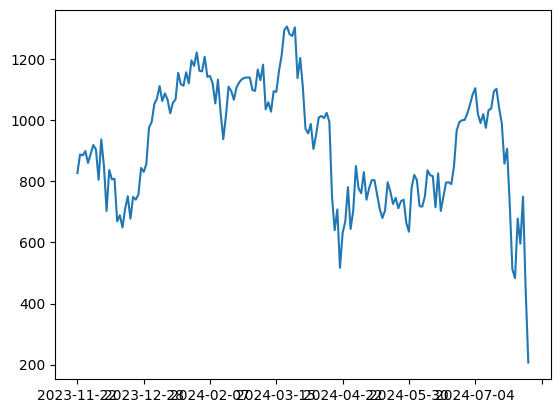

In [ ]:
ms = pd.Series(nums, index=minervini_stocks.keys())
ms.plot()

In [ ]:
nums = []
for key in minervini_stocks.keys():
    nums.append(len(minervini_stocks[key]))


In [ ]:
from copy import deepcopy
_dfx = deepcopy(dfx)

In [ ]:
dfx["6777"]

In [ ]:
dfx["2086"].columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'code', '33業種区分', '17業種区分',
       '規模区分', 'flg1', 'flg2', 'flg3', 'flg4', 'flg5', 'flg6', 'flg7',
       'mtt_signal', 'mansfield_rs', 'minervini_rs', '52w_high', '52w_low',
       'is_52w_high', 'is_52w_low', 'momentum1', 'momentum25', 'is_advance',
       'is_decline', 'volume_advance', 'volume_decline'],
      dtype='object')

In [ ]:
overall_hh = []
overall_hl = []
start = dt.date.today()
# for date in pd.date_range(start=start, end=dt.date.today(), freq="d"):
for date in topix.loc[start:].index:
    date = date.date()
    daily_hh = []
    daily_hl = []
    for ticker in ticker_lst:
        try:
            if date not in dfx[ticker].index:
                continue
            dfx[ticker].index = pd.to_datetime(dfx[ticker].index)
            _data = dfx[ticker].loc[date.strftime("%Y-%m-%d")]
            if _data["is_52w_high"] == True:
                daily_hh.append(_data)
            if _data["is_52w_low"] == True:
                daily_hl.append(_data)
        except KeyError as err:
            print(f"({ticker}): KeyError occured", err)
            continue
        except AttributeError as err:
            print(f"({ticker}): AttributeError occured", err)
            continue
    # Check if daily_hh or daily_hl are empty before concatenating
    if daily_hh:
        result_hh = pd.concat(daily_hh, axis=1).T
        overall_hh.append(result_hh)
    if daily_hl:
        result_hl = pd.concat(daily_hl, axis=1).T
        overall_hl.append(result_hl)

In [ ]:
ohh_df = pd.concat(overall_hh, axis=0)
ohl_df = pd.concat(overall_hl, axis=0)

In [ ]:
sector_hh = []
for date in ohh_df.index:
    _temp = ohh_df.loc[date].groupby("17業種区分").count()["code"]
    _temp.name = date.strftime("%Y-%m-%d")
    sector_hh.append(_temp)
sector_hh_df = pd.concat(sector_hh, axis=1).T
sector_hh_df

17業種区分,-,エネルギー資源,不動産,医薬品,商社・卸売,小売,建設・資材,情報通信・サービスその他,機械,素材・化学,自動車・輸送機,運輸・物流,金融（除く銀行）,鉄鋼・非鉄,電力・ガス,電機・精密,食品,銀行
2024-01-10,74.0,2.0,12.0,3.0,41.0,35.0,38.0,49.0,21.0,16.0,8.0,8.0,5.0,2.0,3.0,20.0,15.0,NaN
2024-01-10,74.0,2.0,12.0,3.0,41.0,35.0,38.0,49.0,21.0,16.0,8.0,8.0,5.0,2.0,3.0,20.0,15.0,NaN
2024-01-10,74.0,2.0,12.0,3.0,41.0,35.0,38.0,49.0,21.0,16.0,8.0,8.0,5.0,2.0,3.0,20.0,15.0,NaN
2024-01-10,74.0,2.0,12.0,3.0,41.0,35.0,38.0,49.0,21.0,16.0,8.0,8.0,5.0,2.0,3.0,20.0,15.0,NaN
2024-01-10,74.0,2.0,12.0,3.0,41.0,35.0,38.0,49.0,21.0,16.0,8.0,8.0,5.0,2.0,3.0,20.0,15.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-02,17.0,NaN,1.0,NaN,NaN,NaN,NaN,3.0,NaN,1.0,NaN,NaN,1.0,NaN,NaN,2.0,NaN,NaN
2024-08-02,17.0,NaN,1.0,NaN,NaN,NaN,NaN,3.0,NaN,1.0,NaN,NaN,1.0,NaN,NaN,2.0,NaN,NaN
2024-08-02,17.0,NaN,1.0,NaN,NaN,NaN,NaN,3.0,NaN,1.0,NaN,NaN,1.0,NaN,NaN,2.0,NaN,NaN
2024-08-02,17.0,NaN,1.0,NaN,NaN,NaN,NaN,3.0,NaN,1.0,NaN,NaN,1.0,NaN,NaN,2.0,NaN,NaN


In [ ]:
sector_hh_df.to_csv("sector_hh.csv")

In [ ]:
sector_hl = []
for date in ohl_df.index:
    _temp = ohl_df.loc[date].groupby("17業種区分").count()["code"]
    _temp.name = date.strftime("%Y-%m-%d")
    sector_hl.append(_temp)
sector_hl_df = pd.concat(sector_hl, axis=1).T
sector_hl_df = sector_hl_df.drop_duplicates()
sector_hl_df.to_csv("sector_hl.csv")

In [ ]:
sector_hh_df = sector_hh_df.drop_duplicates()
sector_hl_df = sector_hl_df.drop_duplicates()

In [ ]:
sector_hl_df.to_csv("sector_hl.csv")

In [ ]:
difference = pd.DataFrame(index=sector_hh_df.index)
for col in sector_hh_df.columns:
    difference[col] = sector_hh_df[col] - sector_hl_df[col]
difference = difference.fillna(0)
fig = px.line(difference,
              x=difference.index,
              y=difference.columns,
              title="Sector HL",
              template="ggplot2"

              )
fig.show()

In [ ]:
fig = px.line(sector_hl_df,
              x=sector_hl_df.index,
              y=sector_hl_df.columns,
              title="Sector HL",

              )
fig.show()

In [ ]:
date = dt.date(2024, 7, 31)
dateset =
hl_list = []
hh_list = []
for ticker in ticker_lst:
    try:
        dfx[ticker].index = pd.to_datetime(dfx[ticker].index)
        _data = dfx[ticker].loc[date.strftime("%Y-%m-%d")]
        if _data["is_52w_high"] == True:
            hl_list.append(_data)
        if _data["is_52w_low"] == True:
            hh_list.append(_data)
    except KeyError as err:
        print(f"({ticker}): KeyError occured", err)
        continue
    except AttributeError as err:
        print(f"({ticker}): AttributeError occured", err)
        continue
result = pd.concat(hl_list, axis=1).T
today = result.groupby("17業種区分").count()["code"].T
today.name = date.strftime("%Y-%m-%d")

(2031): KeyError occured '2024-07-31'
(2032): KeyError occured '2024-07-31'
(2033): KeyError occured '2024-07-31'
(2034): KeyError occured '2024-07-31'
(2036): KeyError occured '2024-07-31'
(2037): KeyError occured '2024-07-31'
(2038): KeyError occured '2024-07-31'
(2040): KeyError occured '2024-07-31'
(2041): KeyError occured '2024-07-31'
(2042): KeyError occured '2024-07-31'
(2043): KeyError occured '2024-07-31'
(2044): KeyError occured '2024-07-31'
(2046): KeyError occured '2024-07-31'
(2047): KeyError occured '2024-07-31'
(2048): KeyError occured '2024-07-31'
(2065): KeyError occured '2024-07-31'
(2067): KeyError occured '2024-07-31'
(2068): KeyError occured '2024-07-31'
(2086): KeyError occured '2024-07-31'
(9919): KeyError occured '2024-07-31'


In [ ]:
def _calculate_market_ad_hhhl(df, tickers, stat_date=None, end_date=None):
    df_list = []
    # start = pd.to_datetime(dt.date(2009, 1, 1))
    # end = pd.to_datetime(dt.date(2024, 8, 1))
    start = pd.to_datetime(dt.date(2024, 8, 1))
    end = pd.to_datetime(start + relativedelta(days=1))

    for i, ticker in enumerate(tickers):
        if ticker in ('162A', '163A'):
            continue
        try:
            _data = df[ticker].copy()
            _data.reset_index(inplace=True)
            _data["Date"] = pd.to_datetime(_data["Date"])
            _data = _data.loc[_data["Date"].between(start, end)]
            _data = _data.loc[_data["Date"].notna()]
            df_list.append(_data)
        except KeyError as err:
            print(f"({ticker}): KeyError occured", err)
            continue
        except AttributeError as err:
            print(f"({ticker}): AttributeError occured", err)
            continue
        if (i >= 500) & (i % 500 == 0):
            print(f"{i}({ticker}) done.")

    result = pd.concat(df_list, axis=0)
    result["is_52w_high"] = result["is_52w_high"].astype(bool)
    result["is_52w_low"] = result["is_52w_low"].astype(bool)
    hhl = result.groupby("Date").sum()[["is_52w_high", "is_52w_low",
                                       "is_advance", "is_decline",
                                       "volume_advance", "volume_decline",
                                        "mtt_signal"]]
    total = result.groupby("Date").count()["code"]
    hhl["total"] = total

    return hhl


In [ ]:
hhl = _calculate_market_ad_hhhl(dfx, ticker_lst)
hhl.to_csv("hhl_20240802.csv")

500(224A) done.
1000(3195) done.
1500(4107) done.
2000(5070) done.
2500(6346) done.
3000(7236) done.
3500(8136) done.
4000(9509) done.


In [ ]:
hhl = _calculate_market_ad_hhhl(dfx, ticker_lst)
hhl

500(224A) done.
1000(3195) done.
1500(4107) done.
2000(5070) done.
2500(6346) done.
3000(7236) done.
3500(8136) done.
4000(9509) done.


,is_52w_high,is_52w_low,is_advance,is_decline,volume_advance,volume_decline,mtt_signal,total
Date,,,,,,,,
2023-01-04,0,0,832,2871,777204445,1010525980,0,3986
2023-01-05,0,0,1368,2285,730467856,1096044251,0,3986
2023-01-06,0,0,2450,1147,997202418,783796366,0,3986
2023-01-10,0,0,1433,2194,562686788,1164868976,0,3987
2023-01-11,0,0,2337,1227,1084164367,628575530,0,3986
...,...,...,...,...,...,...,...,...
2024-07-26,20,67,1639,2189,833399735,1397475620,483,4185
2024-07-29,61,43,2737,1146,1856846729,517967961,678,4184
2024-07-30,58,90,1438,2417,1213796582,1055069878,596,4182


In [ ]:
hhl

,is_52w_high,is_52w_low,is_advance,is_decline,volume_advance,volume_decline,mtt_signal,total
Date,,,,,,,,
2023-01-04,0,0,832,2871,777204445,1010525980,0,3986
2023-01-05,0,0,1368,2285,730467856,1096044251,0,3986
2023-01-06,0,0,2450,1147,997202418,783796366,0,3986
2023-01-10,0,0,1433,2194,562686788,1164868976,0,3987
2023-01-11,0,0,2337,1227,1084164367,628575530,0,3986
...,...,...,...,...,...,...,...,...
2024-07-26,20,67,1639,2189,833399735,1397475620,483,4185
2024-07-29,61,43,2737,1146,1856846729,517967961,678,4184
2024-07-30,58,90,1438,2417,1213796582,1055069878,596,4182


In [ ]:
def _get_full_list(dfx, tickers):
    df_list = []

    for ticker in tickers:
        try:
            _data = dfx[ticker].copy()
            # _data = _data.loc[dt.date(2020, 1, 1): dt.date(2021, 1, 1)]
            _data.reset_index(inplace=True)
            # print(_data.columns)
            _data["Date"] = pd.to_datetime(_data["Date"])
            # _data = _data.loc[_data["Date"].between(pd.to_datetime('2023-01-01'), pd.to_datetime('2024-07-31'))]
            _data = _data.loc[_data["Date"].notna()]
            df_list.append(_data)
        except KeyError as err:
            print(f"({ticker}): KeyError occured", err)
            continue
        except AttributeError as err:
            print(f"({ticker}): AttributeError occured", err)
            continue
    result = pd.concat(df_list, axis=0)
    return result

In [ ]:
result = _get_full_list(dfx, ticker_lst)

In [ ]:
res = deepcopy(result)

In [ ]:
min_date = result["Date"].min()
max_date = result["Date"].max()
date_list = result["Date"].unique()

In [ ]:
result.loc[result["Date"].between(pd.to_datetime("2010-06-30"), pd.to_datetime("2024-08-01"))]["Date"].unique()

<DatetimeArray>
['2010-06-30 00:00:00', '2010-07-01 00:00:00', '2010-07-02 00:00:00',
 '2010-07-05 00:00:00', '2010-07-06 00:00:00', '2010-07-07 00:00:00',
 '2010-07-08 00:00:00', '2010-07-09 00:00:00', '2010-07-12 00:00:00',
 '2010-07-13 00:00:00',
 ...
 '2024-07-19 00:00:00', '2024-07-22 00:00:00', '2024-07-23 00:00:00',
 '2024-07-24 00:00:00', '2024-07-25 00:00:00', '2024-07-26 00:00:00',
 '2024-07-29 00:00:00', '2024-07-30 00:00:00', '2024-07-31 00:00:00',
 '2024-08-01 00:00:00']
Length: 3469, dtype: datetime64[ns]

In [ ]:
rsi_list = []
for date in date_list:
    _data = result.loc[result["Date"]==date].copy()
    if _data.empty:
        continue
    _data["mansfield_rs"] = pd.to_numeric(_data["mansfield_rs"], errors='coerce')
    _data["minervini_rs"] = pd.to_numeric(_data["minervini_rs"], errors='coerce')
    # Check if there are any valid values before applying qcut
    cols = ["Date", "code"]
    if _data["mansfield_rs"].dropna().size > 0:
        _data.loc[:, "mansfield_rsi"] = pd.qcut(_data["mansfield_rs"], 100, labels=False)
        cols.append("mansfield_rs")
        cols.append("mansfield_rsi")
    if _data["minervini_rs"].dropna().size > 0:
        _data.loc[:, "minervini_rsi"] = pd.qcut(_data["minervini_rs"], 100, labels=False)
        cols.append("minervini_rs")
        cols.append("minervini_rsi")

    try:
        rsi_list.append(_data[cols])
    except KeyError as err:
        # print(f"({date}): KeyError occured", err)
        continue
#     res.loc[res["Date"]==date, "mansfield_rs"] = pd.to_numeric(res.loc[res["Date"]==date, "mansfield_rs"], errors='coerce')
#     res.loc[res["Date"]==date, "minervini_rs"] = pd.to_numeric(res.loc[res["Date"]==date, "minervini_rs"], errors='coerce')
#     res.loc[res["Date"]==date, "mansfield_rsi"] = pd.qcut(res.loc[res["Date"]==date, "mansfield_rs"], 100, labels=False, duplicates='drop') # Drop duplicate bin edges
#     res.loc[res["Date"]==date, "minervini_rsi"] = pd.qcut(res.loc[res["Date"]==date, "minervini_rs"], 100, labels=False, duplicates='drop') # Drop duplicate bin edges
#     rsi_list.append(res.loc[res["Date"]==date, ["Date", "code", "mansfield_rsi", "minervini_rsi"]])

rsi_df = pd.concat(rsi_list, axis=0)

NameError: name 'date_list' is not defined

In [ ]:
rsi_df.to_csv("rsi_20090101_20240801.csv")

In [ ]:
rsi_df = pd.read_csv("rsi_20090101_20240801.csv").iloc[:, 1:]

<ipython-input-22-3efb2a35ebbf>:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  rsi_df = pd.read_csv("rsi_20090101_20240801.csv").iloc[:, 1:]


In [ ]:
rsi_df["rs_ma"] = result[""]

In [ ]:
this_year = rsi_df.loc[rsi_df["Date"].between("2023-01-03", "2023-12-31")]
this_year.to_csv("rsi_20230101-20231231.csv")

In [ ]:
# 2010-01-18
rsi_df = (rsi_df.iloc[984270:])[["Date", "code", "mansfield_rsi", "minervini_rsi"]]
rsi_df.to_csv("rsi_20100630_20240801.csv")

In [ ]:
df_hhl.to_csv("hhl_20090101_20240731.csv")

<Axes: xlabel='Date'>

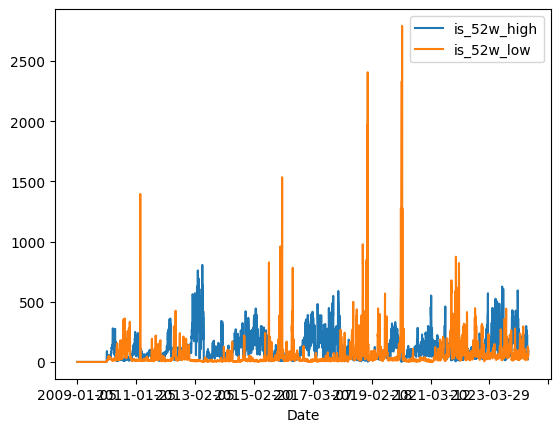

In [ ]:
df_hhl.set_index("Date", inplace=True)
df_hhl[["is_52w_high", "is_52w_low"]].plot()

<Axes: xlabel='Date'>

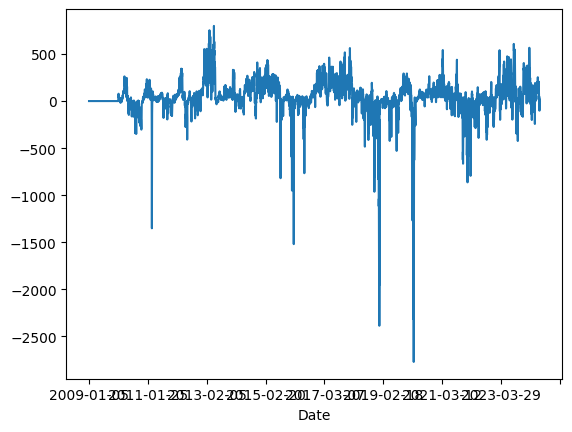

In [ ]:
df_hhl["HH-HL"] = df_hhl["is_52w_high"] - df_hhl["is_52w_low"]
df_hhl["HH-HL"].plot()

In [ ]:
error_tickers = []
for i, ticker in enumerate(ticker_lst):
    try:
        _dfx = dfx[ticker].copy()
        if "Date" in _dfx.columns:
            _dfx["Date"] = pd.to_datetime(_dfx["Date"])
        else:
            _dfx.reset_index(inplace=True)
            _dfx["Date"] = pd.to_datetime(_dfx["Date"])
        _dfx = _dfx.loc[_dfx["Date"].between(pd.to_datetime('2020-01-01'), pd.to_datetime('2023-01-01'))]
        # _dfx.reset_index(inplace=True)
        _dfx = _dfx.loc[_dfx["Date"].notna()]
    except KeyError as err:
        print(f"({ticker}): KeyError occured", err)
        error_tickers.append(ticker)
        continue
    except AttributeError as err:
        print(f"({ticker}): AttributeError occured", err)
        error_tickers.append(ticker)
        continue
    if _dfx.empty:
        # print(f"{ind}: {ticker}({row['name']})'s dfx[ticker]Frame is empty, skipping...")
        print(f"{ticker} is empty, skipping...")
        continue

    result = pd.concat([result, _dfx], axis=0)
    if (i >= 100) & (i % 100 == 0):
        print(f"{i}({ticker}) done.")

<ipython-input-113-015f840d1aa3>:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result = pd.concat([result, _dfx], axis=0)


130A is empty, skipping...
133A is empty, skipping...
135A is empty, skipping...
137A is empty, skipping...
138A is empty, skipping...
140A is empty, skipping...
141A is empty, skipping...
142A is empty, skipping...
143A is empty, skipping...
1444 is empty, skipping...
145A is empty, skipping...
146A is empty, skipping...
147A is empty, skipping...
148A is empty, skipping...
149A is empty, skipping...
150A is empty, skipping...
151A is empty, skipping...
153A is empty, skipping...
155A is empty, skipping...
156A is empty, skipping...
157A is empty, skipping...
159A is empty, skipping...
160A is empty, skipping...
(162A): KeyError occured 'Date'
(163A): KeyError occured 'Date'
165A is empty, skipping...
166A is empty, skipping...
167A is empty, skipping...
200(1680) done.
168A is empty, skipping...
170A is empty, skipping...
173A is empty, skipping...
175A is empty, skipping...
176A is empty, skipping...
177A is empty, skipping...
178A is empty, skipping...
179A is empty, skipping...
18

KeyboardInterrupt: 

In [ ]:
def _get_hhl(df):
    df["is_52w_high"] = df["is_52w_high"].astype(bool)
    df["is_52w_low"] = df["is_52w_low"].astype(bool)
    df["is_advance"] = df["is_advance"].astype(bool)
    df["is_decline"] = df["is_decline"].astype(bool)

    result = df.groupby("Date").sum()[["is_52w_high", "is_52w_low",
                                       "is_advance", "is_decline",
                                       "volume_advance", "volume_decline"]]
    result["trin"] = (result["is_advance"] / result["volume_advance"]) / (result["is_decline"] / result["volume_decline"])
    result["trin_13ma"] = _ema(result["trin"], 13)
    result["hh-hl"] = result["is_52w_high"] - result["is_52w_low"]

    return result

In [ ]:
# Preparative Calculation
error_tickers = []
for i, ticker in enumerate(ticker_lst):
    try:
        data = dfx[ticker]
    except KeyError as err:
        print(f"({ticker}): KeyError occured")
        error_tickers.append(ticker)
        continue
    if data.empty:
        # print(f"{ind}: {ticker}({row['name']})'s DataFrame is empty, skipping...")
        print(f"{ticker} is empty, skipping...")
        continue
    size = min(len(dfx[ticker]), 250)
    # 5 - 12
    dfx[ticker][["flg1", "flg2", "flg3", "flg4", "flg5", "flg6", "flg7", "mtt_signal"]]\
        = _mtt_signal(dfx[ticker], ma_period, look_back)
    # 13
    dfx[ticker]["mansfield_rs"] = get_relative_performance(dfx[ticker], interval)
    dfx[ticker]["minervini_rs"] = get_relative_strength(dfx[ticker], interval)
    # 15
    dfx[ticker]["52w_high"] = _historical_high(dfx[ticker]["High"], size)
    dfx[ticker]["52w_low"] = _historical_low(dfx[ticker]["Low"], size)
    # 16
    dfx[ticker]["is_52w_high"] = dfx[ticker]["High"] >= dfx[ticker]["52w_high"]
    dfx[ticker]["is_52w_low"] = dfx[ticker]["Low"] <= dfx[ticker]["52w_low"]
    # 18
    dfx[ticker]["momentum1"] = dfx[ticker]["Close"].diff()
    dfx[ticker]["momentum25"] = dfx[ticker]["Close"].diff(25)

    if (i >= 1000) and (i % 1000 == 0):
        print(f"{i}-th ticker done.")


162A is empty, skipping...
163A is empty, skipping...


<ipython-input-70-66240d036cd9>:93: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  return 100 * (0.4 * (close.pct_change(q1)) + 0.2 * (close.pct_change(q2)) + 0.2 * close.pct_change(q3) + 0.2 * close.pct_change(q4))
<ipython-input-70-66240d036cd9>:93: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  return 100 * (0.4 * (close.pct_change(q1)) + 0.2 * (close.pct_change(q2)) + 0.2 * close.pct_change(q3) + 0.2 * close.pct_change(q4))
<ipython-input-70-66240d036cd9>:93: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in 

1000-th ticker done.
2000-th ticker done.


<ipython-input-70-66240d036cd9>:93: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  return 100 * (0.4 * (close.pct_change(q1)) + 0.2 * (close.pct_change(q2)) + 0.2 * close.pct_change(q3) + 0.2 * close.pct_change(q4))
<ipython-input-70-66240d036cd9>:93: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  return 100 * (0.4 * (close.pct_change(q1)) + 0.2 * (close.pct_change(q2)) + 0.2 * close.pct_change(q3) + 0.2 * close.pct_change(q4))


3000-th ticker done.


<ipython-input-70-66240d036cd9>:93: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  return 100 * (0.4 * (close.pct_change(q1)) + 0.2 * (close.pct_change(q2)) + 0.2 * close.pct_change(q3) + 0.2 * close.pct_change(q4))


4000-th ticker done.


<ipython-input-70-66240d036cd9>:93: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  return 100 * (0.4 * (close.pct_change(q1)) + 0.2 * (close.pct_change(q2)) + 0.2 * close.pct_change(q3) + 0.2 * close.pct_change(q4))


In [ ]:
df = pd.DataFrame(
    columns=["Date", "code", "name", "flg1", "flg2", "flg3",
            "flg4", "flg5", "flg6", "flg7", "mtt_signal",
            "mansfield_rs", "mansfield_rsi",
            "minervini_rs", "minervini_rsi",
            "52w_high", "52w_low",
            "is_52w_high", "is_52w_low",
            "High", "Low", "Close", "Volume",
            "momentum", "momentum25"]
)
df[["code", "name"]] = tickers[["コード", "銘柄名"]]

error_tickers = []
for ind, row in df.iterrows():
    try:
        data = dfx[row["code"]]
    except KeyError as err:
        print(f"{ind}({row['code']}): KeyError occured")
        error_tickers.append(row["code"])
        continue
    if data.empty:
        print(f"{ind}: {row['code']}({row['name']})'s DataFrame is empty, skipping...")
        continue

    try:
        # Date
        df.iat[ind, 0] = data.iloc[-1].name.date()
        # flg1
        df.iat[ind, 3] = data.iat[-1, 5]
        # flg2
        df.iat[ind, 4] = data.iat[-1, 6]
        # flg3
        df.iat[ind, 5] = data.iat[-1, 7]
        # flg4
        df.iat[ind, 6] = data.iat[-1, 8]
        # flg5
        df.iat[ind, 7] = data.iat[-1, 9]
        # flg6
        df.iat[ind, 8] = data.iat[-1, 10]
        # flg7
        df.iat[ind, 9] = data.iat[-1, 11]
        # mtt_signal
        df.iat[ind, 10] = data.iat[-1, 12]
        # mansfield_rs
        df.iat[ind, 11] = data.iat[-1, 13]
        # minervini_rs
        df.iat[ind, 13] = data.iat[-1, 14]
        # 52w_high
        df.iat[ind, 15] = data.iat[-1, 15]
        # 52w_low
        df.iat[ind, 16] = data.iat[-1, 16]
        # is_52w_high
        df.iat[ind, 17] = data.iat[-1, 17]
        # is_52w_low
        df.iat[ind, 18] = data.iat[-1, 18]

        # High
        df.iat[ind, 19] = data.iat[-1, 1]
        # Low
        df.iat[ind, 20] = data.iat[-1, 2]
        # Close
        df.iat[ind, 21] = data.iat[-1, 3]
        # Volume
        df.iat[ind, 22] = data.iat[-1, 4]
        # momentum
        df.iat[ind, 23] = data.iat[-1, 19]
        # momentum25
        df.iat[ind, 24] = data.iat[-1, 20]

    except IndexError as err:
        print(f"{ind}({row['code']}): Error Occured")
        continue
    # if (ind >= 500) & (ind % 500 == 0):
    #     print(f"{ind}({row['code']}) done.")
    if (ind >= 1000) and (ind % 1000 == 0):
        print(f"{ind}-th ticker done.")
result = pd.concat([result, df], axis=0)


171: 162A(ＡＩセレクトメガトレンドＥＴＮ)'s DataFrame is empty, skipping...
176: 163A(半導体フォーカス日本株ＥＴＮ)'s DataFrame is empty, skipping...
1000-th ticker done.
2000-th ticker done.
3000-th ticker done.
4000-th ticker done.


In [ ]:
file_prefix = dt.date.today().strftime("%Y-%m-%d")
result.to_csv(f"./{file_prefix}_result.csv")

In [ ]:
result["Date"] = pd.to_datetime(result["Date"])
result["code"] = result["code"].astype("str")
result = result.loc[result["Date"].notna()]


1582703

In [ ]:
latest = result.loc[result["Date"] == '2024-07-31']
latest["mansfield_rs"] = pd.to_numeric(latest["mansfield_rs"], errors='coerce')
latest["minervini_rs"] = pd.to_numeric(latest["minervini_rs"], errors='coerce')
latest["mansfield_rsi"] = pd.qcut(latest["mansfield_rs"], 100, labels=False, duplicates='drop') # Drop duplicate bin edges
latest["minervini_rsi"] = pd.qcut(latest["minervini_rs"], 100, labels=False, duplicates='drop') # Drop duplicate bin edges


<ipython-input-95-5e7a2ea3c77f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  latest["mansfield_rs"] = pd.to_numeric(latest["mansfield_rs"], errors='coerce')
<ipython-input-95-5e7a2ea3c77f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  latest["minervini_rs"] = pd.to_numeric(latest["minervini_rs"], errors='coerce')
<ipython-input-95-5e7a2ea3c77f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

In [ ]:
latest["is_52w_high"] = latest["is_52w_high"].astype(int)
latest["is_52w_low"] = latest["is_52w_low"].astype(int)
HH = latest.groupby("Date").sum()["is_52w_high"]
HL = latest.groupby("Date").sum()["is_52w_low"]
hh_hl = pd.concat([HH, HL], axis=1)
hh_hl["hh-hl"] = HH - HL
latest["is_ac"] = latest["momentum"] > 0
latest["is_dis"] = latest["momentum"] < 0
latest["a_vol"] = np.where(latest["is_ac"], latest["Volume"], 0)
latest["d_vol"] = np.where(latest["is_dis"], latest["Volume"], 0)
a_count = latest.groupby("Date").sum()["is_ac"]
d_count = latest.groupby("Date").sum()["is_dis"]
a_vol = latest.groupby("Date").sum()["a_vol"]
d_vol = latest.groupby("Date").sum()["d_vol"]
trin = (a_count / a_vol) / (d_count / d_vol)
hh_hl["trin"] = trin
hh_hl["trin_13ma"] = _ema(trin, 13)
hh_hl.to_csv("hh_hl_updater.csv")

<ipython-input-107-fade2ccf997d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  latest["is_52w_high"] = latest["is_52w_high"].astype(int)
<ipython-input-107-fade2ccf997d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  latest["is_52w_low"] = latest["is_52w_low"].astype(int)
<ipython-input-107-fade2ccf997d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pan

In [ ]:
latest.to_csv("latest_result.csv")

In [ ]:
topix

,Open,High,Low,Close,Volume
Date,,,,,
2009-01-05,871.01,883.68,870.99,875.91,1.145434e+09
2009-01-06,883.15,883.15,872.38,876.20,2.154792e+09
2009-01-07,881.43,896.21,880.26,888.25,2.805087e+09
2009-01-08,879.64,879.69,860.16,860.89,2.110675e+09
2009-01-09,863.82,866.15,849.32,855.02,1.893242e+09
...,...,...,...,...,...
2024-07-25,2753.38,2755.87,2705.47,2709.86,2.273023e+09
2024-07-26,2705.21,2727.27,2695.45,2699.54,1.928589e+09
2024-07-29,2731.83,2767.94,2721.50,2759.67,1.775957e+09


In [ ]:
# calculate each date
for i in range(1, len(topix)):
    df = pd.DataFrame(
        columns=["Date", "code", "name", "flg1", "flg2", "flg3",
                "flg4", "flg5", "flg6", "flg7", "mtt_signal",
                "mansfield_rs", "mansfield_rsi",
                "minervini_rs", "minervini_rsi",
                "52w_high", "52w_low",
                "is_52w_high", "is_52w_low",
                "High", "Low", "Close", "Volume",
                "momentum", "momentum25"]
    )
    df[["code", "name"]] = tickers[["コード", "銘柄名"]]
    for ind, row in df.iterrows():
        if row["code"] in error_tickers:
            continue
        try:
            data = dfx[row["code"]].iloc[:-i]
        except KeyError as err:
            print(f"{ind}({row['code']}): KeyError occured")
            continue
        if data.empty:
            # print(f"{ind}: {row['code']}({row['name']})'s DataFrame is empty, skipping...")
            continue

        try:
            # Date
            df.iat[ind, 0] = data.iloc[-1].name.date()
            # flg1
            df.iat[ind, 3] = data.iat[-1, 5]
            # flg2
            df.iat[ind, 4] = data.iat[-1, 6]
            # flg3
            df.iat[ind, 5] = data.iat[-1, 7]
            # flg4
            df.iat[ind, 6] = data.iat[-1, 8]
            # flg5
            df.iat[ind, 7] = data.iat[-1, 9]
            # flg6
            df.iat[ind, 8] = data.iat[-1, 10]
            # flg7
            df.iat[ind, 9] = data.iat[-1, 11]
            # mtt_signal
            df.iat[ind, 10] = data.iat[-1, 12]
            # mansfield_rs
            df.iat[ind, 11] = data.iat[-1, 13]
            # minervini_rs
            df.iat[ind, 13] = data.iat[-1, 14]
            # 52w_high
            df.iat[ind, 15] = data.iat[-1, 15]
            # 52w_low
            df.iat[ind, 16] = data.iat[-1, 16]
            # is_52w_high
            df.iat[ind, 17] = data.iat[-1, 17]
            # is_52w_low
            df.iat[ind, 18] = data.iat[-1, 18]

            # High
            df.iat[ind, 19] = data.iat[-1, 1]
            # Low
            df.iat[ind, 20] = data.iat[-1, 2]
            # Close
            df.iat[ind, 21] = data.iat[-1, 3]
            # Volume
            df.iat[ind, 22] = data.iat[-1, 4]
            # momentum
            df.iat[ind, 23] = data.iat[-1, 19]
            # momentum25
            df.iat[ind, 24] = data.iat[-1, 20]

        except IndexError as err:
            print(f"{ind}({row['code']}): Error Occured")
            continue

    result = pd.concat([result, df], axis=0)
    if (i >= 100) & (i % 100 == 0):
        print(f"{i}日分終了")
        result.to_csv("temp.csv", index=False)

100日分終了
200日分終了
300日分終了


KeyboardInterrupt: 

In [ ]:
result = result.loc[result["Date"].notna()]

In [ ]:
len(result)

2818687

In [ ]:
result["Date"] = pd.to_datetime(result["Date"])
result["code"] = result["code"].astype("str")
result = result.loc[result["Date"].notna()]
result = result.loc[result["Date"].dt.year.isin([2023, 2024])]
result.to_csv("full_result.csv", index=False)

In [ ]:
result.loc[result["Date"].dt.year.isin([2023, 2024])]

,Date,code,name,flg1,flg2,flg3,flg4,flg5,flg6,flg7,...,52w_high,52w_low,is_52w_high,is_52w_low,High,Low,Close,Volume,momentum,momentum25
0,2024-07-30,1301,極洋,True,True,True,True,True,False,True,...,4175.000000,3364.908713,False,False,4055.000000,3985.000000,3995.000000,16300.0,-55.000000,-10.000000
1,2024-07-30,1305,ｉＦＴＯＰＩＸ（年１回決算型）,True,True,True,True,False,True,True,...,3092.000000,2274.515651,False,False,2893.000000,2868.000000,2890.000000,147990.0,-3.500000,20.874756
2,2024-07-30,1306,ＮＦ ＴＯＰＩＸ連動型上場投信,True,True,True,True,False,True,True,...,3060.000000,2250.289666,False,False,2863.000000,2836.500000,2857.000000,1565060.0,-6.000000,16.309570
3,2024-07-30,1308,上場インデックスファンドＴＯＰ,True,True,True,True,False,True,True,...,3025.000000,2224.296079,False,False,2875.000000,2803.000000,2847.000000,1958037.0,14.000000,39.169434
4,2024-07-30,1309,上海株指数・上証５０連動型上場,False,True,True,True,False,False,True,...,42550.000000,35000.000000,False,False,39200.000000,39000.000000,39000.000000,58.0,-100.000000,-1990.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1627330,2023-01-04,9991,ジェコス,True,True,True,False,True,False,True,...,798.665527,701.679688,False,False,786.421782,773.236267,773.236267,22600.0,-15.069153,5.650879
1627331,2023-01-04,9993,ヤマザワ,False,False,False,False,True,False,True,...,1656.443175,1130.000000,False,False,1308.000000,1275.000000,1279.000000,9700.0,-6.000000,18.000000
1627332,2023-01-04,9994,やまや,False,True,False,False,True,False,True,...,2668.000000,2391.000000,False,False,2490.000000,2482.000000,2483.000000,4600.0,-16.000000,-43.000000
1627333,2023-01-04,9996,サトー商会,False,False,False,False,False,False,True,...,1430.859131,1074.500184,False,False,1101.507324,1091.861901,1101.507324,1200.0,11.574463,-18.326294


In [ ]:
result = pd.read_csv("full_result.csv")
result["Date"] = pd.to_datetime(result["Date"])
result["code"] = result["code"].astype("str")
result = result.loc[result["Date"].notna()]

In [ ]:
file_prefix = dt.date.today().strftime("%Y-%m-%d")
result.to_csv(f"./{file_prefix}_result.csv")
result.to_pickle(f"./{file_prefix}_result.pkl")

In [ ]:
# Convert 'mansfield_rs' and 'rs' columns to numeric, handling errors
result["mansfield_rs"] = pd.to_numeric(result["mansfield_rs"], errors='coerce')
result["minervini_rs"] = pd.to_numeric(result["minervini_rs"], errors='coerce')

In [ ]:
rs = pd.DataFrame(
    columns=["Date", "code", "name", "flg1", "flg2", "flg3",
            "flg4", "flg5", "flg6", "flg7", "mtt_signal",
            "mansfield_rs", "mansfield_rsi",
            "minervini_rs", "minervini_rsi",
            "52w_high", "52w_low",
            "is_52w_high", "is_52w_low",
            "High", "Low", "Close", "Volume",
            "momentum", "momentum25"]
)

In [ ]:
for i, date in enumerate(result["Date"].unique().dropna()):
    try:
        data = result.loc[result["Date"] == date]
        data["mansfield_rsi"] = pd.qcut(data["mansfield_rs"], 100, labels=False, duplicates='drop') # Drop duplicate bin edges
        data["minervini_rsi"] = pd.qcut(data["minervini_rs"], 100, labels=False, duplicates='drop') # Drop duplicate bin edges
        rs = pd.concat([rs, data], axis=0)
        # data.to_csv(f"./{date}_result.csv")
        if (i >= 100) & (i % 100 == 0):
            print(f"{i}日分終了")
    except IndexError as err:
        print(f"{date}: Error Occured")
        continue

<ipython-input-33-4e446756e546>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["mansfield_rsi"] = pd.qcut(data["mansfield_rs"], 100, labels=False, duplicates='drop') # Drop duplicate bin edges
<ipython-input-33-4e446756e546>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["minervini_rsi"] = pd.qcut(data["minervini_rs"], 100, labels=False, duplicates='drop') # Drop duplicate bin edges
<ipython-input-33-4e446756e546>:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA e

100日分終了
200日分終了
300日分終了


In [ ]:
result["is_ac"] = result["momentum"] > 0
result["is_dis"] = result["momentum"] < 0
result["a_vol"] = np.where(result["is_ac"], result["Volume"], 0)
result["d_vol"] = np.where(result["is_dis"], result["Volume"], 0)
a_count = result.groupby("Date").sum()["is_ac"]
d_count = result.groupby("Date").sum()["is_dis"]
a_vol = result.groupby("Date").sum()["a_vol"]
d_vol = result.groupby("Date").sum()["d_vol"]
trin = (a_count / a_vol) / (d_count / d_vol)
hh_hl["trin"] = trin
hh_hl["trin_13ma"] = _ema(trin, 13)
hh_hl.to_csv("hh_hl.csv")

In [ ]:
hh_hl = hh_hl.drop("tin_13ma", axis=1)
hh_hl.to_csv("hh_hl.csv")

In [ ]:
HH = result.groupby("Date").sum()["is_52w_high"]
HL = result.groupby("Date").sum()["is_52w_low"]
hh_hl = pd.concat([HH, HL], axis=1)
hh_hl["hh-hl"] = HH - HL
hh_hl.tail(20)

,is_52w_high,is_52w_low,hh-hl
Date,,,
2024-07-02,254,39,215
2024-07-03,243,36,207
2024-07-04,315,44,271
2024-07-05,217,54,163
2024-07-08,153,54,99
2024-07-09,208,60,148
2024-07-10,191,58,133
2024-07-11,271,50,221
2024-07-12,147,25,122


<Axes: xlabel='Date'>

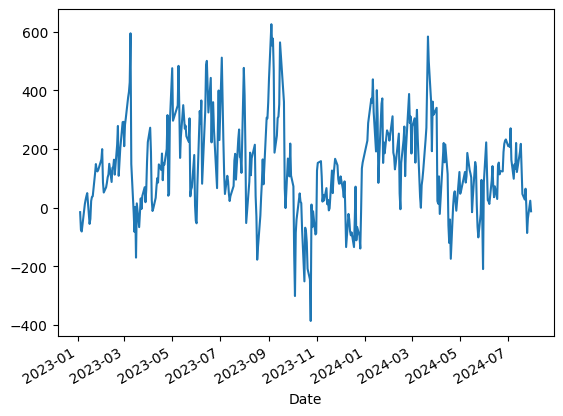

In [ ]:
hh_hl["diff"].plot()

In [ ]:
rs.to_csv("market_info.csv")

In [ ]:
from google.colab import files
files.download('full_result.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
def trend_template_and_52w_hl(file, end_date=dt.date.today()+relativedelta(days=1)):

    tickers = read_ticker_file(file)

    start_date = end_date - relativedelta(years=5)
    topix = pdr.DataReader("^TPX", start=start_date, data_source="stooq").sort_index()
    topix.to_csv("./topix.csv")

    # start_date = dt.date.today() - relativedelta(years=2)
    length = max(
        len(topix.loc[end_date - relativedelta(weeks=53):]),
        len(topix.loc[end_date - relativedelta(days=255):])
    )

    result = pd.DataFrame(
        columns=["code", "name", "flg1", "flg2", "flg3",
                "flg4", "flg5", "flg6", "flg7", "mtt_signal",
                # 10
                 "mansfield_rs", "rs", "rs_index",
                "52w_high", "52w_low", "High", "Low", "Close"]
    )

    result[["code", "name"]] = tickers[["コード", "銘柄名"]]


    ma_period = (50, 150, 200)
    lookback = (20, 200)
    for ind, row in result.iterrows():
        # if row["code"] in ("162A", "163A", "2073", "221A"):
        #     print(f"Passed, because {ind}-th ticker({row['コード']}) is invalid.")
        #     continue
        df = _retrieve_data(row["code"], start=start_date)
        if df.empty:
            print(f"{ind}({row['code']}): DataFrame is empty, skipping...")
            continue  # Skip to the next iteration
        size = min(len(df), 250)
        data = _mtt_signal(df, ma_period, lookback)
        data["rs"] = get_relative_strength(df, interval)
        data["mansfield_rs"] = get_relative_performance(df, interval)
        data["52w_high"] = _historical_high(df["High"], size)
        data["52w_low"] = _historical_low(df["Low"], size)
        # data["52w_high"] = _historical_high(df["High"], 250)
        # data["52w_low"] = _historical_low(df["Low"], 250)
        try:
            result.iat[ind, 2] = data.iat[-1, 0]
            result.iat[ind, 3] = data.iat[-1, 1]
            result.iat[ind, 4] = data.iat[-1, 2]
            result.iat[ind, 5] = data.iat[-1, 3]
            result.iat[ind, 6] = data.iat[-1, 4]
            result.iat[ind, 7] = data.iat[-1, 5]
            result.iat[ind, 8] = data.iat[-1, 6]
            result.iat[ind, 9] = data.iat[-1, 7]
            result.iat[ind, 10] = data.iat[-1, 8]
            result.iat[ind, 11] = data.iat[-1, 9]
            result.iat[ind, 13] = data.iat[-1, 10]
            result.iat[ind, 14] = data.iat[-1, 11]
            result.iat[ind, 15] = df.iat[-1, 1]
            result.iat[ind, 16] = df.iat[-1, 2]
            result.iat[ind, 17] = df.iat[-1, 3]
        except IndexError as err:
            print(f"{ind}({row['code']}): errored")
            continue
        if (ind >= 500) & (ind % 500 == 0):
            print(f"{ind}({row['code']}) done.")

    result["is_52w_high"] = result["High"] >= result["52w_high"]
    result["is_52w_low"] = result["Low"] <= result["52w_low"]

    file_prefix = end_date.strftime("%Y-%m-%d")


    result.to_csv(f"./{file_prefix}_result.csv")
    result.to_pickle(f"./{file_prefix}_result.pkl")

    # sorted_df = _sort_and_map_rs(result)
    # result = result.set_index("code")
    # result["rs_index"] = sorted_df["rs_index"]
    # result.to_csv(f"./{file_prefix}_rs_52whl.csv")
    # result.to_pickle(f"./{file_prefix}_rs_52whl.pkl")

    # Convert 'mansfield_rs' and 'rs' columns to numeric, handling errors
    result["mansfield_rs"] = pd.to_numeric(result["mansfield_rs"], errors='coerce')
    result["rs"] = pd.to_numeric(result["rs"], errors='coerce')
    result["mansfield_rs_index"] = pd.qcut(result["mansfield_rs"], 100, labels=False)
    result["minervini_rs_index"] = pd.qcut(result["rs"], 100, labels=False)

    nkx_tickers = pd.read_csv("./n225_ticker.csv")
    nkx_tickers.set_index("銘柄コード", inplace=True)
    nkx = nkx_tickers.index.astype("str")
    result["is_n225"] = result.apply(lambda x: True if x.name in nkx else False, axis=1)

    stocks = pd.read_excel("https://www.jpx.co.jp/markets/statistics-equities/misc/tvdivq0000001vg2-att/data_j.xls")
    stocks = stocks.set_index("コード")
    stocks.index = stocks.index.astype("str")
    stocks = stocks[["市場・商品区分", "33業種区分", "17業種区分", "規模区分"]]

    rs = pd.merge(left=result, right=stocks, left_index=True, right_index=True)

    rs.to_csv(f"./{file_prefix}rs_52whl_stocks.csv")
    rs.to_pickle(f"./{file_prefix}rs_52whl_stocks.pkl")

    return rs


In [ ]:
topix = pdr.DataReader("^TPX", start="2000-01-01", data_source="stooq").sort_index()
topix.to_csv("./topix.csv")

In [ ]:
file = "./screener_result.csv"
result = trend_template_and_52w_hl(file)

ERROR:yfinance:162A.T: Period 'max' is invalid, must be one of ['1d', '5d']


171(162A): DataFrame is empty, skipping...


ERROR:yfinance:163A.T: Period 'max' is invalid, must be one of ['1d', '5d']


176(163A): DataFrame is empty, skipping...


<ipython-input-3-810ee626cfba>:88: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  return 100 * (0.4 * (close.pct_change(q1)) + 0.2 * (close.pct_change(q2)) + 0.2 * close.pct_change(q3) + 0.2 * close.pct_change(q4))
<ipython-input-3-810ee626cfba>:88: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  return 100 * (0.4 * (close.pct_change(q1)) + 0.2 * (close.pct_change(q2)) + 0.2 * close.pct_change(q3) + 0.2 * close.pct_change(q4))
<ipython-input-3-810ee626cfba>:88: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any

500(2248) done.


<ipython-input-3-810ee626cfba>:88: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  return 100 * (0.4 * (close.pct_change(q1)) + 0.2 * (close.pct_change(q2)) + 0.2 * close.pct_change(q3) + 0.2 * close.pct_change(q4))


1000(3192) done.
1500(4100) done.
2000(5036) done.


<ipython-input-3-810ee626cfba>:88: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  return 100 * (0.4 * (close.pct_change(q1)) + 0.2 * (close.pct_change(q2)) + 0.2 * close.pct_change(q3) + 0.2 * close.pct_change(q4))


2500(6343) done.
3000(7231) done.
3500(8133) done.
4000(9507) done.


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


In [ ]:
end_date=dt.date.today()+relativedelta(days=1)
file_prefix = end_date.strftime("%Y-%m-%d")

result = pd.read_pickle("./2024-07-31_result.pkl")
result["mansfield_rs"] = pd.to_numeric(result["mansfield_rs"], errors='coerce')
result["rs"] = pd.to_numeric(result["rs"], errors='coerce')
result["mansfield_rs_index"] = pd.qcut(result["mansfield_rs"], 100, labels=False)
result["minervini_rs_index"] = pd.qcut(result["rs"], 100, labels=False)

nkx_tickers = pd.read_csv("./n225_ticker.csv")
nkx_tickers.set_index("銘柄コード", inplace=True)
nkx = nkx_tickers.index.astype("str")
result["is_n225"] = result.apply(lambda x: True if x.name in nkx else False, axis=1)
# result
# stocks = pd.read_excel("https://www.jpx.co.jp/markets/statistics-equities/misc/tvdivq0000001vg2-att/data_j.xls")
# stocks = stocks.set_index("コード")
# stocks.index = stocks.index.astype("str")
# stocks = stocks[["市場・商品区分", "33業種区分", "17業種区分", "規模区分"]]
# result.to_csv(f"./{file_prefix}rs_52whl_stocks.csv")
# result.to_pickle(f"./{file_prefix}rs_52whl_stocks.pkl")
# rs = pd.merge(left=result, right=stocks, left_index=True, right_index=True)
# rs

# rs.to_csv(f"./{file_prefix}rs_52whl_stocks.csv")
# rs.to_pickle(f"./{file_prefix}rs_52whl_stocks.pkl")


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


In [ ]:
result["mansfield_rs"] = pd.to_numeric(result["mansfield_rs"], errors='coerce')
result["rs"] = pd.to_numeric(result["rs"], errors='coerce')
result["mansfield_rs_index"] = pd.qcut(result["mansfield_rs"], 100, labels=False)
result["minervini_rs_index"] = pd.qcut(result["rs"], 100, labels=False)

In [ ]:
nkx_tickers = pd.read_csv("./n225_ticker.csv")
nkx_tickers.set_index("銘柄コード", inplace=True)
nkx = nkx_tickers.index.astype("str")
result["is_n225"] = result.apply(lambda x: True if x.name in nkx else False, axis=1)

In [ ]:
result.to_csv(f"./{file_prefix}rs_52whl_stocks.csv")
result.to_pickle(f"./{file_prefix}rs_52whl_stocks.pkl")

In [ ]:
# rs = pd.read_pickle("./2024-07-31rs_52whl_stocks.pkl")
rs.loc[rs["code"]=="3791"].T

,1309
code,3791
name,ＩＧポート
flg1,True
flg2,True
flg3,True
flg4,False
flg5,True
flg6,True
flg7,True
mtt_signal,0


In [ ]:
file = "./screener_result.csv"
tickers = read_ticker_file(file)
tickers = tickers[["コード", "銘柄名", "市場"]]

n225_ticker = pd.read_csv("./n225_ticker.csv")
n225_ticker["銘柄コード"] = n225_ticker["銘柄コード"].astype("str")
tickers["日経平均"] = tickers.apply(lambda x: True if x["コード"] in n225_ticker["銘柄コード"].to_list() else False, axis=1)
jpx400 = pd.read_csv("https://www.jpx.co.jp/markets/indices/jpx-nikkei400/tvdivq00000031dd-att/jpx_nikkei_index_400_weight_jp.csv", encoding="shift-jis")
jpx400 = jpx400.iloc[:-1]
jpx400["コード"] = jpx400["コード"].astype("str").apply(lambda x: x.split(".")[0])
tickers["JPX400"] = tickers.apply(lambda x: True if x["コード"] in jpx400["コード"].to_list() else False, axis=1)
jpx400[["コード", "銘柄名"]].to_csv("./jpx400.csv")
jpx_middle_small = pd.read_csv("https://www.jpx.co.jp/markets/indices/jpx-nikkei400/nlsgeu0000022qyg-att/jpx_nikkei_mid_small_weight_jp.csv", encoding="shift-jis")
jpx_middle_small = jpx_middle_small.iloc[:-1]
jpx_middle_small["コード"] = jpx_middle_small["コード"].astype("str").apply(lambda x: x.split(".")[0])
tickers["JPX中小型"] = tickers.apply(lambda x: True if x["コード"] in jpx_middle_small["コード"].to_list() else False, axis=1)
jpx_middle_small[["コード", "銘柄名"]].to_csv("./jpx_middle_small.csv")

start_date = dt.date(2000, 1, 1)
nikkei = get_stock_price("^N225", start=start_date)

In [ ]:
n225_ticker = pd.read_csv("./n225_ticker.csv")
n225_ticker["銘柄コード"] = n225_ticker["銘柄コード"].astype("str")
tickers["日経平均"] = tickers.apply(lambda x: True if x["コード"] in n225_ticker["銘柄コード"].to_list() else False, axis=1)
jpx400 = pd.read_csv("https://www.jpx.co.jp/markets/indices/jpx-nikkei400/tvdivq00000031dd-att/jpx_nikkei_index_400_weight_jp.csv", encoding="shift-jis")
jpx400 = jpx400.iloc[:-1]
jpx400["コード"] = jpx400["コード"].astype("str").apply(lambda x: x.split(".")[0])
tickers["JPX400"] = tickers.apply(lambda x: True if x["コード"] in jpx400["コード"].to_list() else False, axis=1)
jpx400[["コード", "銘柄名"]].to_csv("./jpx400.csv")
jpx_middle_small = pd.read_csv("https://www.jpx.co.jp/markets/indices/jpx-nikkei400/nlsgeu0000022qyg-att/jpx_nikkei_mid_small_weight_jp.csv", encoding="shift-jis")
jpx_middle_small = jpx_middle_small.iloc[:-1]
jpx_middle_small["コード"] = jpx_middle_small["コード"].astype("str").apply(lambda x: x.split(".")[0])
tickers["JPX中小型"] = tickers.apply(lambda x: True if x["コード"] in jpx_middle_small["コード"].to_list() else False, axis=1)
jpx_middle_small[["コード", "銘柄名"]].to_csv("./jpx_middle_small.csv")

In [ ]:
temp = get_stock_price("1301", start=dt.date(2007, 1, 1))
df = pd.DataFrame(
    columns=["52w_High", "52w_Low", "total", "52w_High_NKX", "52w_Low_NKX",
             "52w_High_JPX400", "52w_Low_JPX400", "52w_High_JPXMS", "52w_Low_JPXMS"],
    index=temp.index
)
df["52w_High"], df["52w_Low"], df["total"], df["52w_High_NKX"], df["52w_Low_NKX"] = 0, 0, 0, 0, 0
df["52w_High_JPX400"], df["52w_Low_JPX400"], df["52w_High_JPXMS"], df["52w_Low_JPXMS"] = 0, 0, 0, 0
hh_ticker = []
hl_ticker = []
error_ticker = []

for ind, ticker in tickers.iterrows():
    try:
        if ticker["コード"] in ("162A", "163A"):
            print(f"Passed, because {ind}-th ticker({ticker['コード']}) is invalid.")
            continue
        # elif ticker["コード"] in ("223A", "224A"):
        #     stock = yf.Ticker(f"{ticker['コード']}.T")
        #     data = stock.history(period="max").tz_localize(None)
        else:
            data = get_stock_price(ticker["コード"], start=dt.date(2007, 1, 1), end=dt.date.today())
    except KeyError as err:
        print(f"{ind}({ticker['コード']}): KeyError under the retriever")
        error_ticker.append(ticker["コード"])
        df.to_pickle("temp.pkl")
        continue

    try:
        # data = data.dropna()
        # data["Volume"] = data["Volume"].replace(0, np.nan)
        # data = data.dropna(subset=["Volume"])
        data.dropna(subset=["Open", "High", "Low", "Close"], inplace=True)
        if data.empty:
            print(f"Passed, because {ind}-th ticker({ticker['コード']}) is empty.")
            continue
        length = min(len(data), 250)
        if length < 20:
            print(f"Passed, because {ind}-th ticker({ticker['コード']}) is too short.")
            continue
        data["counter"] = data["Close"].notna()
        data["52w_High"] = _historical_high(data["High"], 250)
        data["52w_Low"] = _historical_low(data["Low"], 250)
        data["is_52w_High"] = data["High"] >= data["52w_High"]
        data["is_52w_Low"] = data["Low"] <= data["52w_Low"]
        data.dropna(inplace=True)
        counter = data["Close"].notna()
    except KeyError as err:
        print(f"{ind}({ticker['コード']}): KeyError under the calculater")
        error_ticker.append(ticker["コード"])
        df.to_pickle("temp.pkl")
        continue

    try:
        last_entry = data.iloc[-1]
        if last_entry["is_52w_High"]:
            hh_ticker.append(ticker["コード"])
        if last_entry["is_52w_Low"]:
            hl_ticker.append(ticker["コード"])

        df.loc[data.index, "52w_High"] += data["is_52w_High"]
        df.loc[data.index, "52w_Low"] += data["is_52w_Low"]
        df.loc[data.index, "total"] += counter

        if ticker["日経平均"]:
            df.loc[data.index, "52w_High_NKX"] += data["is_52w_High"]
            df.loc[data.index, "52w_Low_NKX"] += data["is_52w_Low"]
        if ticker["JPX400"]:
            df.loc[data.index, "52w_High_JPX400"] += data["is_52w_High"]
            df["52w_Low_JPX400"] += data["is_52w_Low"]

        if ticker["JPX中小型"]:
            df.loc[data.index, "52w_High_JPXMS"] += data["is_52w_High"]
            df.loc[data.index, "52w_Low_JPXMS"] += data["is_52w_Low"]

        if (ind >= 500) & (ind % 500 == 0):
            print(f"{ind}({ticker['コード']}) done.")

    except IndexError as err:
        print(f"{ind}({ticker['コード']}): IndexError")
        error_ticker.append(ticker["コード"])
        df.to_pickle("temp.pkl")
        continue

    except KeyError as err:
        print(f"{ind}({ticker['コード']}): KeyError ")
        error_ticker.append(ticker["コード"])
        df.to_pickle("temp.pkl")
        continue

    except ValueError as err:
        print(f"{ind}({ticker['コード']}): ValueError")
        error_ticker.append(ticker["コード"])
        df.to_pickle("temp.pkl")
        continue

    except TypeError as err:
        print(f"{ind}({ticker['コード']}): TypeError")
        error_ticker.append(ticker["コード"])
        df.to_pickle("temp.pkl")
        continue

    except AttributeError as err:
        print(f"{ind}({ticker['コード']}): AttributeError")
        error_ticker.append(ticker["コード"])
        df.to_pickle("temp.pkl")
        continue

    except Exception as err:
        print(f"{ind}({ticker['コード']}): The other Error")
        error_ticker.append(ticker["コード"])
        df.to_pickle("temp.pkl")
        continue


df.to_csv("52w_high_and_low.csv")
df.to_pickle("52w_high_and_low.pkl")


5(130A): IndexError
18(133A): IndexError
27(135A): IndexError
39(137A): IndexError
45(138A): IndexError
51(140A): IndexError
56(141A): IndexError
59(142A): IndexError
67(143A): IndexError
78(145A): IndexError
83(146A): IndexError
91(147A): IndexError
100(148A): IndexError
110(149A): IndexError
111(150A): IndexError
115(151A): IndexError
116(153A): IndexError
130(155A): IndexError
136(156A): IndexError
144(157A): IndexError
154(159A): IndexError
156(160A): IndexError
Passed, because 171-th ticker(162A) is invalid.
Passed, because 176-th ticker(163A) is invalid.
185(165A): IndexError
189(166A): IndexError
199(167A): IndexError
208(168A): IndexError
218(170A): IndexError
232(173A): IndexError
236(175A): IndexError
241(176A): IndexError
246(177A): IndexError
252(178A): IndexError
257(179A): IndexError
264(180A): IndexError
271(181A): IndexError
278(182A): IndexError
286(184A): IndexError
294(186A): IndexError
300(187A): IndexError
306(188A): IndexError
312(189A): IndexError
315(190A): Inde

ERROR:yfinance:215A.T: Period '1mo' is invalid, must be one of ['1d', '5d', 'ytd', 'max']


Passed, because 450-th ticker(215A) is empty.
Passed, because 481-th ticker(221A) is too short.


ERROR:yfinance:223A.T: Period '1mo' is invalid, must be one of ['1d', '5d', 'ytd', 'max']


Passed, because 493-th ticker(223A) is empty.


ERROR:yfinance:224A.T: Period '1mo' is invalid, must be one of ['1d', '5d', 'ytd', 'max']


500(2248): IndexError
Passed, because 502-th ticker(224A) is empty.
508(2255): IndexError
509(2256): IndexError
510(2257): IndexError
511(2258): IndexError
512(2259): IndexError
867(2938): IndexError
869(2962): IndexError
1000(3192) done.
1408(3958): IndexError
1500(4100) done.
1892(4811): IndexError
1928(4896): IndexError
2000(5036) done.
2070(5271): IndexError
2148(5585): IndexError
2149(5586): IndexError
2150(5587): IndexError
2151(5588): IndexError
2152(5589): IndexError
2153(5590): IndexError
2154(5591): IndexError
2155(5592): IndexError
2156(5595): IndexError
2157(5596): IndexError
2158(5597): IndexError
2159(5599): IndexError
2165(5616): IndexError
2166(5618): IndexError
2167(5619): IndexError
2168(5621): IndexError
2213(5842): IndexError
2214(5843): IndexError
2216(5845): IndexError
2222(5867): IndexError
2223(5868): IndexError
2224(5869): IndexError
2225(5870): IndexError
2226(5871): IndexError
2229(5888): IndexError
2230(5889): IndexError
2231(5891): IndexError
2232(5892): In

In [ ]:
temp = get_stock_price("1301", start=dt.date(2007, 1, 1))
df = pd.DataFrame(
    columns=["52w_High", "52w_Low", "total", "52w_High_NKX", "52w_Low_NKX",
             "52w_High_JPX400", "52w_Low_JPX400", "52w_High_JPXMS", "52w_Low_JPXMS"],
    index=temp.index
)
df["52w_High"], df["52w_Low"], df["total"], df["52w_High_NKX"], df["52w_Low_NKX"] = 0, 0, 0, 0, 0
df["52w_High_JPX400"], df["52w_Low_JPX400"], df["52w_High_JPXMS"], df["52w_Low_JPXMS"] = 0, 0, 0, 0


In [ ]:
# data = get_stock_price("1301", start=dt.date(2007, 1, 1), end=dt.date.today())
data = data.dropna()
data["Volume"] = data["Volume"].replace(0, np.nan)
data = data.dropna(subset=["Volume"])
length = min(len(data), 250)
data["counter"] = data["Close"].notna()
data["52w_High"] = _historical_high(data["High"], length)
data["52w_Low"] = _historical_low(data["Low"], length)
data["is_52w_High"] = data["High"] >= data["52w_High"]
data["is_52w_Low"] = data["Low"] <= data["52w_Low"]
df.loc[data.index, "52w_High"] += data["is_52w_High"]
df.loc[data.index, "52w_Low"] += data["is_52w_Low"]
df.loc[data.index, "total"] += data["counter"]

# if tickers["日経平均"]:
#     df.loc[data.index, "52w_High_NKX"] += data["is_52w_High"]
#     df.loc[data.index, "52w_Low_NKX"] += data["is_52w_Low"]
# if tickers["JPX400"]:
#     df.loc[data.index, "52w_High_JPX400"] += data["is_52w_High"]
#     df["52w_Low_JPX400"] += data["is_52w_Low"]

# if tickers["JPX中小型"]:
#     df.loc[data.index, "52w_High_JPXMS"] += data["is_52w_High"]
#     df.loc[data.index, "52w_Low_JPXMS"] += data["is_52w_Low"]

<ipython-input-26-c909f742374e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Volume"] = data["Volume"].replace(0, np.nan)


In [ ]:
data["Volume"] = data["Volume"].replace(0, np.nan)

In [ ]:
topix.loc[topix.Volume!=0]

,Open,High,Low,Close,Volume
Date,,,,,
2008-12-29,846.93,855.33,842.01,854.77,1.239173e+09
2008-12-30,851.58,859.66,849.75,859.24,8.525423e+08
2009-01-05,871.01,883.68,870.99,875.91,1.145434e+09
2009-01-06,883.15,883.15,872.38,876.20,2.154792e+09
2009-01-07,881.43,896.21,880.26,888.25,2.805087e+09
...,...,...,...,...,...
2024-07-25,2753.38,2755.87,2705.47,2709.86,2.273023e+09
2024-07-26,2705.21,2727.27,2695.45,2699.54,1.928589e+09
2024-07-29,2731.83,2767.94,2721.50,2759.67,1.775957e+09


In [ ]:
stock = yf.Ticker("^N225")
df = stock.history(start=dt.date(2009, 1, 1)).tz_localize(None)


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2009-01-05,8991.209961,9127.379883,8987.360352,9043.120117,84900000,0.0,0.0
2009-01-06,9130.009766,9171.030273,9029.940430,9080.839844,154800000,0.0,0.0
2009-01-07,9133.799805,9325.349609,9106.049805,9239.240234,205600000,0.0,0.0
2009-01-08,9143.209961,9148.830078,8876.419922,8876.419922,149900000,0.0,0.0
2009-01-09,8932.709961,8956.849609,8773.200195,8836.799805,137000000,0.0,0.0
...,...,...,...,...,...,...,...
2024-07-25,38524.199219,38557.789062,37825.578125,37869.511719,143000000,0.0,0.0
2024-07-26,37792.871094,38105.960938,37611.191406,37667.410156,124000000,0.0,0.0
2024-07-29,38139.121094,38719.699219,38010.011719,38468.628906,107300000,0.0,0.0


In [ ]:
for i in range(4):

    print(df.iloc[-i].name.date() - relativedelta(years=1))

2008-01-05
2023-07-31
2023-07-30
2023-07-29


In [ ]:
data.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-07-24,3248.620936,3511.888381,3248.620936,3328.097900,306900,0.0,0.0
2024-07-25,3189.013358,3422.476953,3179.078737,3298.294189,322200,0.0,0.0
2024-07-26,3179.078781,3258.555751,3139.340296,3193.980713,225900,0.0,0.0
2024-07-29,3159.209510,3357.901932,3159.209510,3343.000000,240600,0.0,0.0
2024-07-30,3350.000000,3405.000000,3190.000000,3225.000000,236900,22.0,0.0


In [351]:
data['52w_high'] = _historical_high(data['High'], 250)
data['52w_low'] = _historical_low(data['Low'], 250)
data.tail()

,Open,High,Low,Close,Volume,52w_high,52w_low
Date,,,,,,,
2024-07-25,1330.0,1330.0,1302.0,1302.0,500,1559.0,1220.0
2024-07-29,1326.0,1363.0,1314.0,1363.0,2500,1559.0,1220.0
2024-07-30,1359.0,1360.0,1351.0,1351.0,500,1559.0,1220.0
2024-07-31,1351.0,1389.0,1351.0,1389.0,2900,1559.0,1220.0
2024-08-01,1389.0,1400.0,1389.0,1389.0,3600,1559.0,1220.0
